# Анализ отзывов на банки

В данных представлены отзывы на банки с сайта [banki.ru](https://www.banki.ru/)
- body - сам отзыв
- title - название отзыва
- rating - оценка по отзыву, варьируется от 1 до 5
- bank_name - название банка
- date - дата публикации отзыва

Необходимо EDA (Exploratory Data Analysis) по этим данным и сделать несколько выводов (приветствуются визуализации):
- назвать топ-15 банков по числу отзывов
- какой банк из числа топ-15 по отзывов имеет самый высокий средний рейтинг?
- сделать выводы об изменении среднего рейтинга банков по месяцам из топ-5 банков по числу отзывов
- нет ли в данных в целом каких-то странностей на ваш взгляд?
- дополнительный EDA на ваше усмотрение, возможные интересные наблюдения

Необходимо выбрать метрику и построить бинарный классификатор отзывов, добившись при этом лучшей метрики на валидационной выборке (отзывы >=3 считать положительными, <3 - отрицательными)

Будет плюсом визуализация результатов работы модели (ответ на вопрос: почему построенная модель считает этот отзыв положительным или отрицательным?)

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%pip install optuna -q
%pip install eli5 -q
%pip install catboost -q
%pip install joblib -q
%pip install scipy -q
%pip install transformers -q
%pip install pytorch-lightning -q
%pip install torchmetrics -q
%pip install mlxtend -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 348.5/348.5 KB 3.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.0/81.0 KB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 210.6/210.6 KB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 KB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.1/147.1 KB 4.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.0/50.0 KB 2.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.7/112.7 KB 4.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 216.2/216.2 KB 7.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.1/133.1 KB 6.6 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
notebook 5.7.16 r

In [3]:
import os
import time

import optuna

import numpy as np

import json

from sklearn.metrics import classification_report

import IPython.display as ipd

%matplotlib inline
import matplotlib.pyplot as plt

import joblib
import sys


import gc

import sklearn
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split, cross_val_score
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import ConfusionMatrixDisplay,make_scorer , f1_score, mean_squared_error, confusion_matrix, accuracy_score, auc, roc_auc_score, roc_curve, classification_report
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import GridSearchCV

# bag of words
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

from PIL import Image

import pathlib

import csv

import lightgbm as lgbm



import eli5
from eli5.sklearn import PermutationImportance

import pandas as pd

import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

from transformers import BertTokenizerFast as BertTokenizer, BertModel, AdamW, get_linear_schedule_with_warmup
import pytorch_lightning as pl
from torchmetrics.functional import *
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from pytorch_lightning.loggers import TensorBoardLogger
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn


import spacy 
from spacy.lang.ru.stop_words import STOP_WORDS
from spacy.lang.ru import Russian
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator


import re, string
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer

nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('omw-1.4')

#for word embedding
import gensim
from gensim.models import Word2Vec

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


# Загрузка и первичный анализ

In [4]:
# reading the data
data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/tests/parsed_reviews3.csv')

# getting the shape
print(data.shape)

data.head()

(92735, 5)


,body,title,rating,bank_name,date
0,&lt;p&gt;Добрый день&lt;/p&gt;\r\n&lt;p&gt;пиш...,Заблокировали средства,1,Еком Банк,2023-01-03 12:46:11
1,&lt;p&gt;При возврате просроченной задолженнос...,Возврат просроченной задолженномти,1,Тинькофф Банк,2023-01-03 12:31:46
2,&lt;p&gt;07.09.22 ю была оформлена кредитная к...,"Ошибочное начисление комиссии, затягивание про...",1,Банк Открытие,2023-01-03 12:23:11
3,&lt;p&gt;Новый год начинается с приятностей)&l...,Клиентоориентиванность 10 из 10,5,Тинькофф Банк,2023-01-03 12:16:07
4,&lt;p&gt;Увидела на сайте Газпромбанка акцию с...,Как Газпромбанк обманывает клиентов с акционны...,1,Газпромбанк,2023-01-03 12:12:36


Как мы можем заметить, пропуски и пустые значения у нас отсутсвуют, поэтому ничего заменять или удалять не нужно

In [5]:
data.isnull().sum()

body         0
title        0
rating       0
bank_name    0
date         0
dtype: int64

In [6]:
data.info(memory_usage="deep")


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92735 entries, 0 to 92734
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   body       92735 non-null  object
 1   title      92735 non-null  object
 2   rating     92735 non-null  int64 
 3   bank_name  92735 non-null  object
 4   date       92735 non-null  object
dtypes: int64(1), object(4)
memory usage: 154.2 MB


In [7]:
# Подсчитаем кол-во уникальных значений в каждой колонке
for col in data:
    print(col, data[col].nunique())

# Можно заметить, что rating у rating у нас стоит 5 видов значений,
#  но мы их не будем категоризировать, так как мы будем потом работать с этими значениями

body 91832
title 54505
rating 5
bank_name 157
date 91059


Как можно заметить ниже - у нас присутствует дисбаланс в рейтинге

In [8]:
# Подсчитаем кол-во оценок
data["rating"].value_counts()

5    67244
1    18433
4     3466
2     2410
3     1182
Name: rating, dtype: int64

In [9]:
#Агора, ЖК «1-й Нагатинский», 
# Тут мы можем провести анализ по тому, какие банки у нас вообще есть (и банк ли это вообще)
a = data['bank_name'].value_counts()
print(a.to_string())


Тинькофф Банк                                 44864
Хоум Кредит Банк                               9310
Совкомбанк                                     6111
ВТБ                                            3817
СберБанк                                       3490
Альфа-Банк                                     3369
Россельхозбанк                                 3064
Банк Открытие                                  1894
МТС Банк                                       1542
Модульбанк                                     1460
Газпромбанк                                    1314
Московский Кредитный Банк                      1251
Азиатско-Тихоокеанский Банк                    1001
Уральский Банк Реконструкции и Развития         748
Русский Стандарт                                689
Ренессанс Кредит                                686
Почта Банк                                      648
Точка                                           624
Росбанк                                         556
Кредит Европ

In [10]:
# удалить колонки, где имеются данные сверху 
data = data[data.bank_name != "Агора" ]
data = data[data.bank_name != "ЖК «1-й Нагатинский»" ]


data.info(memory_usage="deep")

<class 'pandas.core.frame.DataFrame'>
Int64Index: 92732 entries, 0 to 92734
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   body       92732 non-null  object
 1   title      92732 non-null  object
 2   rating     92732 non-null  int64 
 3   bank_name  92732 non-null  object
 4   date       92732 non-null  object
dtypes: int64(1), object(4)
memory usage: 262.8 MB


In [11]:
# Так или иначе, можно категоризировать банки ! 
data["bank_name"] = data["bank_name"].astype("category")
data['date']= pd.to_datetime(data['date'])

# Добавим колонку с месяцем и неделями. Они нам помогут в обучении модели и в визуализации
data['month'] = data['date'].dt.month
data["month"] = data["month"].astype("category")

data['week'] = data['date'].apply(lambda d: (d.day-1) // 7 + 1)
data["week"] = data["week"].astype("category")

data['target'] = data['rating'].apply(lambda x: "Positive" if x in (3,4,5) else "Negative")
data["target"] = data["target"].astype("category")

data['Target'] = data['rating'].apply(lambda x: 1 if x in (3,4,5) else 0)
data["Target"] = data["Target"].astype("category")

data.info(memory_usage="deep") # Размер увеличился, но теперь банки будет проще категоризировать

<class 'pandas.core.frame.DataFrame'>
Int64Index: 92732 entries, 0 to 92734
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   body       92732 non-null  object        
 1   title      92732 non-null  object        
 2   rating     92732 non-null  int64         
 3   bank_name  92732 non-null  category      
 4   date       92732 non-null  datetime64[ns]
 5   month      92732 non-null  category      
 6   week       92732 non-null  category      
 7   target     92732 non-null  category      
 8   Target     92732 non-null  category      
dtypes: category(5), datetime64[ns](1), int64(1), object(2)
memory usage: 245.6 MB


In [12]:
data.nunique()

body         91829
title        54502
rating           5
bank_name      155
date         91056
month            5
week             5
target           2
Target           2
dtype: int64

In [13]:
# Чистим текст от лишних символов:
data['body'] = data['body'].str.replace(r'&lt;', ' ')
data['body'] = data['body'].str.replace(r'p&gt;', '')
data['body'] = data['body'].str.replace(r'/\r\n', '')
data['body'] = data['body'].str.replace(r'&quot;', '"')
data['body'] = data['body'].str.replace(r'br&gt;', '')

data.head(20)
# Видно, что мы очистили датасет от ненужных символов. Теперь можем приступить к визуализации

,body,title,rating,bank_name,date,month,week,target,Target
0,Добрый день пишу сюда для более скорого разр...,Заблокировали средства,1,Еком Банк,2023-01-03 12:46:11,1,1,Negative,0
1,"При возврате просроченной задолженности, банк...",Возврат просроченной задолженномти,1,Тинькофф Банк,2023-01-03 12:31:46,1,1,Negative,0
2,"07.09.22 ю была оформлена кредитная карта ""12...","Ошибочное начисление комиссии, затягивание про...",1,Банк Открытие,2023-01-03 12:23:11,1,1,Negative,0
3,Новый год начинается с приятностей) Никогда ...,Клиентоориентиванность 10 из 10,5,Тинькофф Банк,2023-01-03 12:16:07,1,1,Positive,1
4,Увидела на сайте Газпромбанка акцию с бонусом...,Как Газпромбанк обманывает клиентов с акционны...,1,Газпромбанк,2023-01-03 12:12:36,1,1,Negative,0
5,"Суперудобный банк, нет комиссии за перевод на...",Отличный банк для ИПшников,5,Точка,2023-01-03 12:08:35,1,1,Positive,1
6,Самый худший банк в стране!!! Сотрудники банк...,Мошенники,1,ВТБ,2023-01-03 12:04:02,1,1,Negative,0
7,"Добрый день. Взяли кредит осенью 2022, ни р...",Звонки!,1,Почта Банк,2023-01-03 11:59:04,1,1,Negative,0
8,Мне очень понравился тинькофф и как оформленн...,Хороший банк,5,Тинькофф Банк,2023-01-03 11:58:32,1,1,Positive,1
9,"В декабре уже было написано, что 512 баллов к...",Глюченный банк,1,Хоум Кредит Банк,2023-01-03 11:47:17,1,1,Negative,0


#какой банк из числа топ-15 по отзывов имеет самый высокий средний рейтинг?


Тут мы наблюдаем топ 15 банков по кол-во отзывов

In [ ]:
top_15_banks = data.groupby(['bank_name'])['body'].count().nlargest(15)
top_15_banks

bank_name
Тинькофф Банк                              44864
Хоум Кредит Банк                            9310
Совкомбанк                                  6111
ВТБ                                         3817
СберБанк                                    3490
Альфа-Банк                                  3369
Россельхозбанк                              3064
Банк Открытие                               1894
МТС Банк                                    1542
Модульбанк                                  1460
Газпромбанк                                 1314
Московский Кредитный Банк                   1251
Азиатско-Тихоокеанский Банк                 1001
Уральский Банк Реконструкции и Развития      748
Русский Стандарт                             689
Name: body, dtype: int64

Как мы видим, Тинькофф имеет самый высокий рейтинг среди всех топ-15 банков. На втором месте Модульбанк, а на третьем Азиатско-Тихоокеанский

In [ ]:
data.loc[data['bank_name'].isin(top_15_banks.index)].groupby(['bank_name'])['rating'].mean().nlargest(15)

bank_name
Тинькофф Банк                              4.783568
Модульбанк                                 4.780137
Азиатско-Тихоокеанский Банк                4.718282
Хоум Кредит Банк                           4.505585
Россельхозбанк                             4.455940
Совкомбанк                                 4.264768
Московский Кредитный Банк                  4.241407
Русский Стандарт                           4.158200
Банк Открытие                              3.543295
Уральский Банк Реконструкции и Развития    3.298128
МТС Банк                                   2.901427
СберБанк                                   2.303725
Газпромбанк                                2.145358
ВТБ                                        1.950223
Альфа-Банк                                 1.714159
Name: rating, dtype: float64

***Почему такие банки попали в данный рейтинг ?***

Моё предположение такое - после блокировки Visa и MasterCard в России - эти банки предоставляли новые карты с системой UnionPay. Именно поэтому они могли оказаться в данном топе и иметь высокие оценки.



---



#сделать выводы об изменении среднего рейтинга банков по месяцам из топ-5 банков по числу отзывов


In [ ]:
top_5_banks = data.groupby(['bank_name'])['body'].count().nlargest(5)
top_5_banks

bank_name
Тинькофф Банк       44864
Хоум Кредит Банк     9310
Совкомбанк           6111
ВТБ                  3817
СберБанк             3490
Name: body, dtype: int64

In [ ]:
res_to_5_banks = (data.loc[data['bank_name'].isin(top_5_banks.index)].groupby([data.date.dt.year,data.date.dt.month, #
            'bank_name'])['rating']
  .mean()).dropna()
res_to_5_banks

date  date  bank_name       
2022  9     ВТБ                 2.073814
            СберБанк            1.920000
            Совкомбанк          3.883544
            Тинькофф Банк       3.888102
            Хоум Кредит Банк    4.060465
      10    ВТБ                 1.914620
            СберБанк            2.777547
            Совкомбанк          3.846561
            Тинькофф Банк       4.865877
            Хоум Кредит Банк    3.591479
      11    ВТБ                 1.993778
            СберБанк            2.562708
            Совкомбанк          4.230511
            Тинькофф Банк       4.841598
            Хоум Кредит Банк    4.001401
      12    ВТБ                 1.896052
            СберБанк            1.868263
            Совкомбанк          4.524676
            Тинькофф Банк       4.650189
            Хоум Кредит Банк    4.626306
2023  1     ВТБ                 1.148148
            СберБанк            1.400000
            Совкомбанк          4.419355
            Тинькофф Банк   

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fd2234caf40>],
      dtype=object)

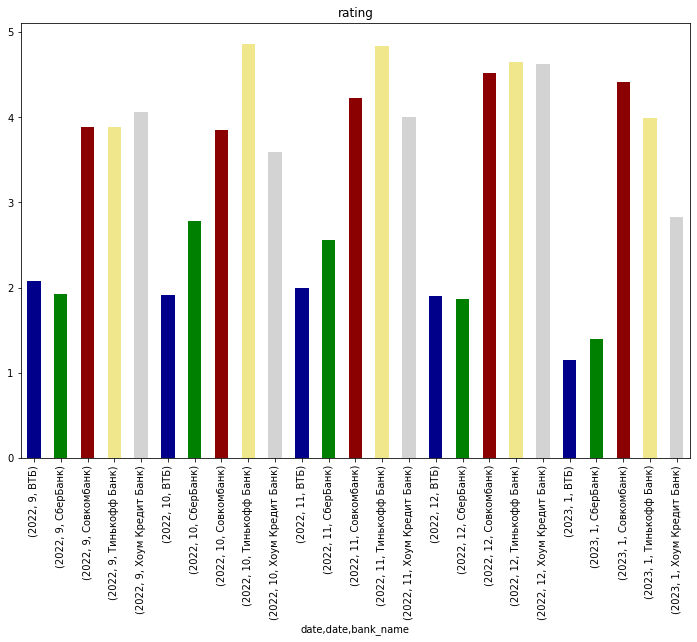

In [ ]:
colors = ['darkblue' if "ВТБ" in x
          else 'khaki' if "Тинькофф Банк" in x 
          else 'green' if "СберБанк" in x
          else 'darkred' if "Совкомбанк" in x 
          else 'lightgrey' for x in res_to_5_banks.index]

res_to_5_banks.plot(kind='bar', subplots=True, sharey=True, figsize=(12,8),color=colors, )

Глядя на график выше можно заметить, что средний рейтинг менялся таким образом у каждого банка:

Небольшое введение: *(Стоит заметить, что данные за январь 2023 года показаны не за весь месяц, а только за 1 половину месяца, поэтому падение наблюдается у всех, что делает анализ января немного необъективным, но его мы поп прежнему не будем убирать из выборки !)* 

---

Втб - его оценка держалась в районе 2 всё время до 2023 года. После 2023 его рейтинг упал примерно до 1, практически как у всех банков. Так или иначе, данный банк показывал стабильность в ноябре и декабре и на данный банк в то время можно было рассчитывать

Сбербанк - напоминает график экспоненциального распределения. Сначала он возрастает, а после идёт на снижение. Причем, когда у всех было падение в 2023 году, сбербанк тоже упал, но у него было одно из самых "мягких" падений. Данный банк тоже наблюдал рост до ноября, а после пошёл на снижение

Совкомбанк - имел довольно-таки стабильный рост до декабря и, пожалуй, имеет самое мягкое падение в 2023 году. Как мы видим - совкомбанк имеет реально самую стабильную аудиторию, которая часто ставит хорошие оценки. (но по поводу оценок мы поговорим позже)

Тинькофф банк - является несомненным лидером по рейтингу с октября по декабрь. Рост наверняка связан с ещё большим объемом рекламы и различных услуг, которые предоставляет банк. Так или иначе, данный банк потерял своё первенство в январе и судя по тенденции - продолжит дальше терять.

Хоум кредит банк - самый неоднозначный банк, который в определенный момент упал, а после повысил свой рейтинг до такого уровня, что тесно конкурировал с тинькофф банком. В январе данный банк больше всех потерял в плане рейтинга. Впоне возможно, что хоум кредит банк имеет столь высокие позиции из-за данной новости - https://www.banki.ru/news/lenta/?id=10977104

#**нет ли в данных в целом каких-то странностей на ваш взгляд?**

Очень часто люди не пишут о положительном опыте. Посмотрите на отзывы и вы заметите, что иногда положительные оценки существуют, но это происходит крайне редко и к этому стоит относиться со скепсисом. 

Давайте же тогда обратим внимание на оценку 5 и посмотрим на сколько же она объективна !

In [ ]:
temp = data["rating"].isin({5}) == True
temp

0        False
1        False
2        False
3         True
4        False
         ...  
92730    False
92731     True
92732    False
92733    False
92734     True
Name: rating, Length: 92732, dtype: bool

In [ ]:
temp=(temp.where(temp == True).dropna().index)
temp_len = len(temp)
temp=temp[int(temp_len/2):]
temp

Int64Index([47603, 47604, 47605, 47606, 47607, 47608, 47609, 47610, 47611,
            47612,
            ...
            92710, 92716, 92720, 92723, 92724, 92725, 92726, 92727, 92731,
            92734],
           dtype='int64', length=33622)

In [ ]:
len(temp)

33622

*Что я сделал ?*

Я удалил половину оценок, где есть оценка 5, чтобы постараться быть более объективным.

In [ ]:
data_analyze = data.copy()
data_analyze=data_analyze.drop(temp, axis=0)
data_analyze.head(5)

,body,title,rating,bank_name,date,month,week,target,Target
0,Добрый день пишу сюда для более скорого разр...,Заблокировали средства,1,Еком Банк,2023-01-03 12:46:11,1,1,Negative,0
1,"При возврате просроченной задолженности, банк...",Возврат просроченной задолженномти,1,Тинькофф Банк,2023-01-03 12:31:46,1,1,Negative,0
2,"07.09.22 ю была оформлена кредитная карта ""12...","Ошибочное начисление комиссии, затягивание про...",1,Банк Открытие,2023-01-03 12:23:11,1,1,Negative,0
3,Новый год начинается с приятностей) Никогда ...,Клиентоориентиванность 10 из 10,5,Тинькофф Банк,2023-01-03 12:16:07,1,1,Positive,1
4,Увидела на сайте Газпромбанка акцию с бонусом...,Как Газпромбанк обманывает клиентов с акционны...,1,Газпромбанк,2023-01-03 12:12:36,1,1,Negative,0


Давайте теперь взглянем на среднюю оценку

In [ ]:
top_10_banks = data_analyze.groupby(['bank_name'])['body'].count().nlargest(10)
top_10_banks

bank_name
Тинькофф Банк       19682
Хоум Кредит Банк     8718
Совкомбанк           4807
ВТБ                  3513
Альфа-Банк           3240
СберБанк             2898
Россельхозбанк       2063
Банк Открытие        1435
МТС Банк             1179
Газпромбанк          1175
Name: body, dtype: int64

In [ ]:
data_analyze.loc[data_analyze['bank_name'].isin(top_10_banks.index)].groupby(['bank_name'])['rating'].mean().nlargest(10)

bank_name
Тинькофф Банк       4.506656
Хоум Кредит Банк    4.472012
Россельхозбанк      4.191953
Совкомбанк          4.065321
Банк Открытие       3.077352
МТС Банк            2.255301
Газпромбанк         1.807660
СберБанк            1.752933
ВТБ                 1.686308
Альфа-Банк          1.583333
Name: rating, dtype: float64

Исходя из тех данных, представленных выше, можно сказать, что скорее-всего рейтинг где-то точно "накручивали". 

Это нормальное явление и с ним ничего нельзя сделать. Заметим, что теперь позиции совершенно иные и на 3 месте у нас стоит россельхоз банк, а такие банки, как тихоокеанский и Модуль банк вовсе исчезли

Субъективно - надо всегда убирать оценку 5 из списка и смотреть, что и как, так как очень часто данная оценка не является действительной

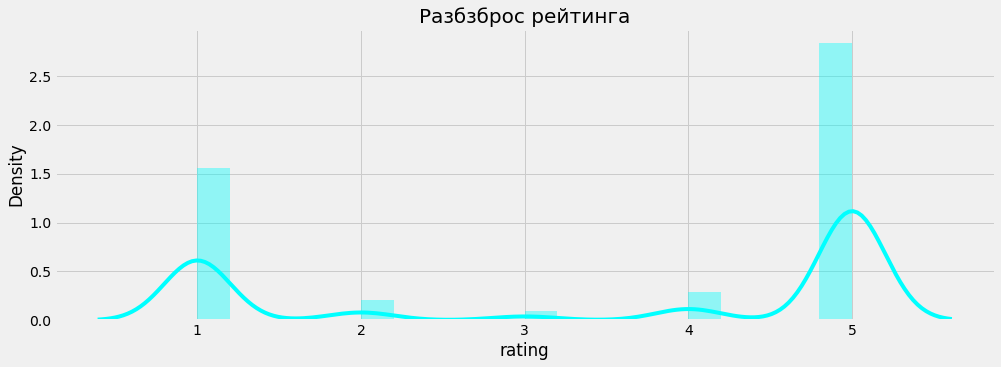

In [ ]:
# Как мы теперь видим, разброс стал чуть меньше, но оценка 5 так всё ещё стоит
plt.style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = (15, 5)
sns.distplot(data_analyze['rating'], color = 'cyan')
plt.title('Разбзброс рейтинга', fontsize = 20)
plt.show()

Text(0.5, 1.0, 'Разброс рейтинга (альт вариант)')

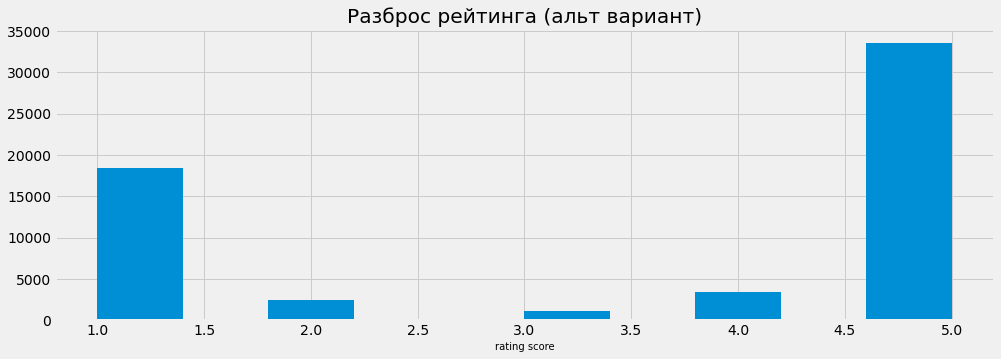

In [ ]:
plt.subplot()
plt.rcParams['figure.figsize'] = (10, 9)
data_analyze['rating'].hist()
plt.xlabel('rating score', size = 10 )
plt.title('Разброс рейтинга (альт вариант)')


---
Давайте уберем оценку 5 ? 

In [ ]:
temp = data["rating"].isin({5}) == True
temp

0        False
1        False
2        False
3         True
4        False
         ...  
92730    False
92731     True
92732    False
92733    False
92734     True
Name: rating, Length: 92732, dtype: bool

In [ ]:
temp=(temp.where(temp == True).dropna().index)
temp

Int64Index([    3,     5,     8,    10,    12,    15,    16,    17,    18,
               22,
            ...
            92710, 92716, 92720, 92723, 92724, 92725, 92726, 92727, 92731,
            92734],
           dtype='int64', length=67243)

In [ ]:
data_analyze = data.copy()
data_analyze=data_analyze.drop(temp, axis=0)
print(len(data_analyze))
data_analyze.head(5)

25489


,body,title,rating,bank_name,date,month,week,target,Target
0,Добрый день пишу сюда для более скорого разр...,Заблокировали средства,1,Еком Банк,2023-01-03 12:46:11,1,1,Negative,0
1,"При возврате просроченной задолженности, банк...",Возврат просроченной задолженномти,1,Тинькофф Банк,2023-01-03 12:31:46,1,1,Negative,0
2,"07.09.22 ю была оформлена кредитная карта ""12...","Ошибочное начисление комиссии, затягивание про...",1,Банк Открытие,2023-01-03 12:23:11,1,1,Negative,0
4,Увидела на сайте Газпромбанка акцию с бонусом...,Как Газпромбанк обманывает клиентов с акционны...,1,Газпромбанк,2023-01-03 12:12:36,1,1,Negative,0
6,Самый худший банк в стране!!! Сотрудники банк...,Мошенники,1,ВТБ,2023-01-03 12:04:02,1,1,Negative,0


Давайте теперь взглянем на среднюю оценку

In [ ]:
top_10_banks = data_analyze.groupby(['bank_name'])['body'].count().nlargest(10)
top_10_banks

bank_name
Тинькофф Банк       3387
ВТБ                 3107
Альфа-Банк          2903
СберБанк            2499
Хоум Кредит Банк    2478
Совкомбанк          1359
Газпромбанк         1003
МТС Банк             865
Банк Открытие        807
Ренессанс Кредит     628
Name: body, dtype: int64

In [ ]:
data_analyze.loc[data_analyze['bank_name'].isin(top_10_banks.index)].groupby(['bank_name'])['rating'].mean().nlargest(10)

bank_name
Хоум Кредит Банк    3.142454
Тинькофф Банк       2.133156
Совкомбанк          1.693893
Банк Открытие       1.581165
Ренессанс Кредит    1.288217
Газпромбанк         1.260219
МТС Банк            1.258960
ВТБ                 1.253299
СберБанк            1.234494
Альфа-Банк          1.186703
Name: rating, dtype: float64

Интересно ! 

Теперь Хоум Кредит Банк занимает лидирующую позицию в рейтинге, тогда же как тинькофф стоит на 2 месте 

Давайте посмотрим на изменение их рейтинга на протяжении всех месяцев !

In [ ]:
top_5_banks = data_analyze.groupby(['bank_name'])['body'].count().nlargest(5)
top_5_banks

bank_name
Тинькофф Банк       3387
ВТБ                 3107
Альфа-Банк          2903
СберБанк            2499
Хоум Кредит Банк    2478
Name: body, dtype: int64

In [ ]:
res_to_5_banks = (data_analyze.loc[data_analyze['bank_name'].isin(top_5_banks.index)].groupby([data_analyze.date.dt.year,data_analyze.date.dt.month, #
            'bank_name'])['rating']
  .mean()).dropna()
res_to_5_banks

date  date  bank_name       
2022  9     Альфа-Банк          1.143098
            ВТБ                 1.233032
            СберБанк            1.158004
            Тинькофф Банк       1.288416
            Хоум Кредит Банк    2.051095
      10    Альфа-Банк          1.193426
            ВТБ                 1.252841
            СберБанк            1.249123
            Тинькофф Банк       2.460594
            Хоум Кредит Банк    1.945652
      11    Альфа-Банк          1.177907
            ВТБ                 1.238042
            СберБанк            1.290541
            Тинькофф Банк       2.418489
            Хоум Кредит Банк    2.125000
      12    Альфа-Банк          1.232964
            ВТБ                 1.278261
            СберБанк            1.223827
            Тинькофф Банк       1.896118
            Хоум Кредит Банк    3.476341
2023  1     Альфа-Банк          1.148148
            ВТБ                 1.148148
            СберБанк            1.400000
            Тинькофф Банк   

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fd2235f2850>],
      dtype=object)

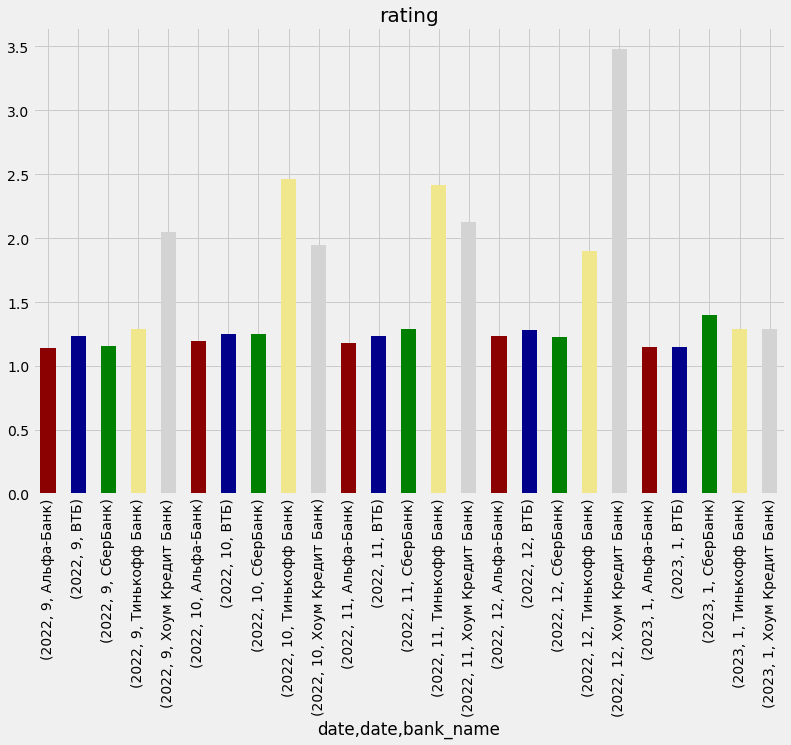

In [ ]:
colors = ['darkblue' if "ВТБ" in x
          else 'khaki' if "Тинькофф Банк" in x 
          else 'green' if "СберБанк" in x
          else 'darkred' if "Альфа-Банк" in x 
          else 'lightgrey' for x in res_to_5_banks.index]

res_to_5_banks.plot(kind='bar', subplots=True, sharey=True, figsize=(12,8),color=colors, )

Как мы видим, Хоум кредит банк и Тинькофф остаются в своеобразном топе, даже когда у них нет оценок 5

**дополнительный EDA на ваше усмотрение, возможные интересные наблюдения**

Доп EDA я укажу уже дальше в своём анализе

# Визуализация

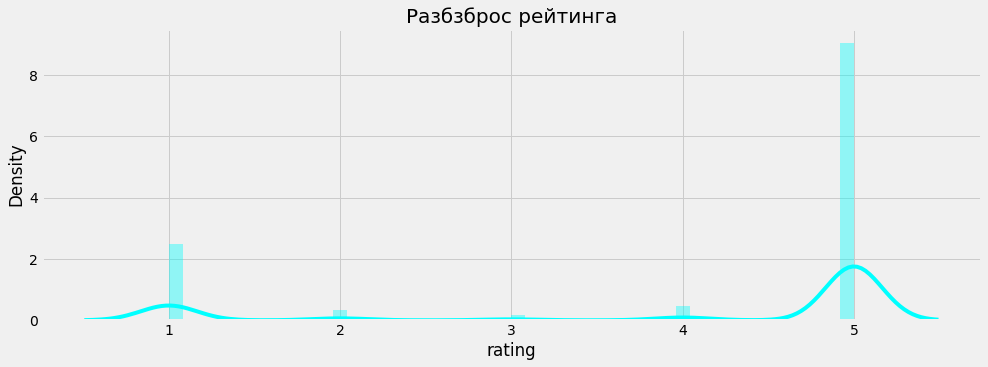

In [ ]:
plt.style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = (15, 5)
sns.distplot(data['rating'], color = 'cyan')
plt.title('Разбзброс рейтинга', fontsize = 20)
plt.show()

Text(0.5, 1.0, 'Разброс рейтинга (альт вариант)')

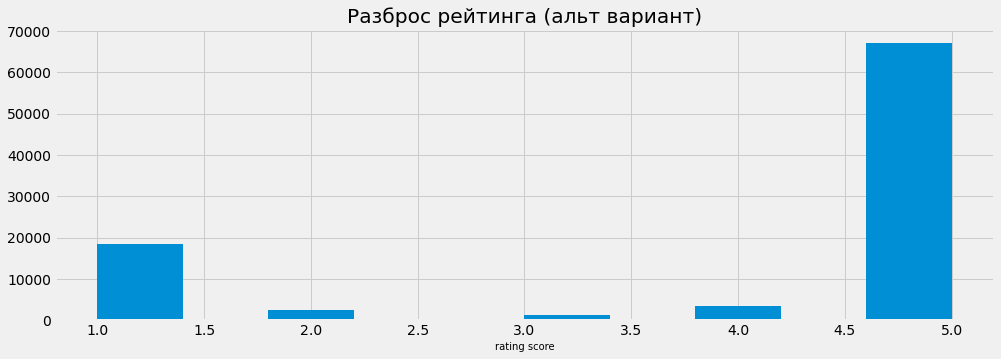

In [ ]:
plt.subplot()
plt.rcParams['figure.figsize'] = (10, 9)
data['rating'].hist()
plt.xlabel('rating score', size = 10 )
plt.title('Разброс рейтинга (альт вариант)')

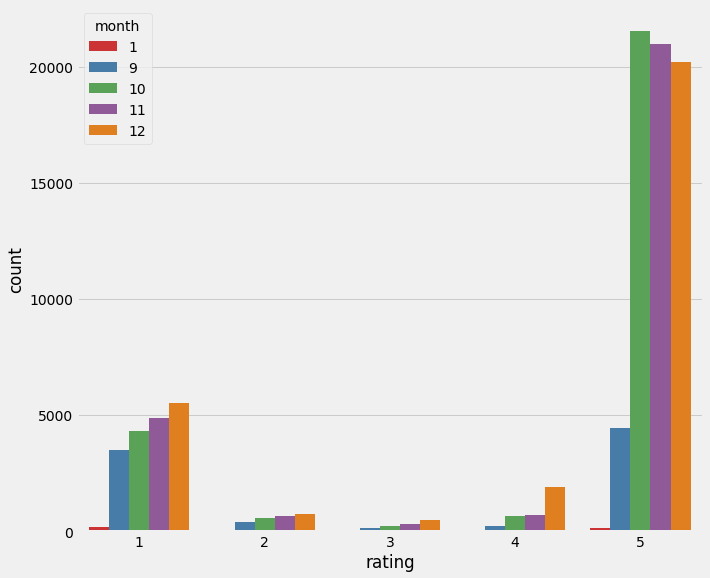

In [ ]:
# Тут можно заметить, что 10 и 12 месяц были самыми богатыми на оценки
ax = sns.countplot(x="rating", data=data,hue="month",palette="Set1")

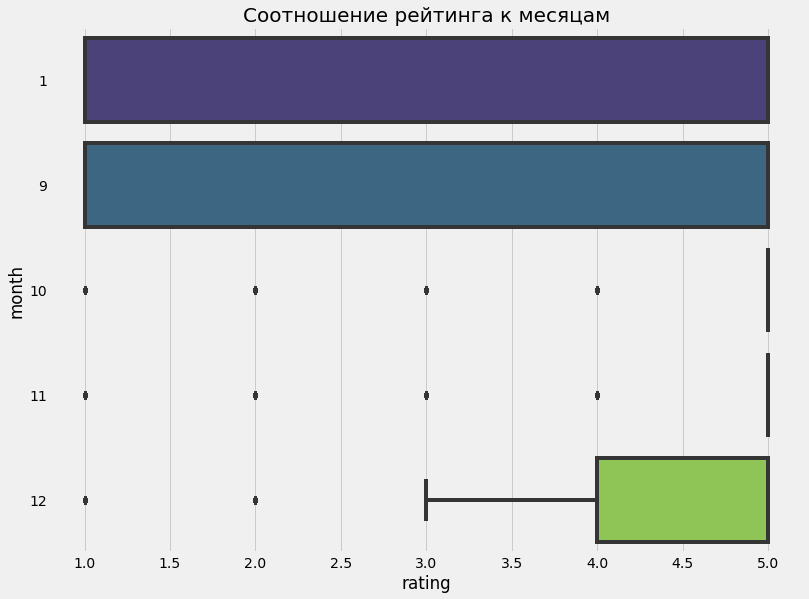

In [ ]:
# Тут мы видим, что только в 1 и 9 месяце встречаются все возможные оценки, тогда как в 12 только с 4 до 5

plt.rcParams['figure.figsize'] = (12, 9)
sns.boxplot(data['rating'], data['month'], palette = 'viridis')
plt.title('Соотношение рейтинга к месяцам', fontsize = 20)
plt.show()

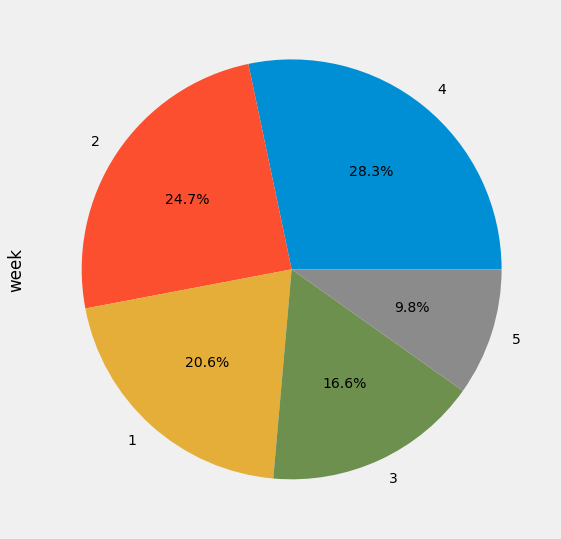

In [ ]:
# Тут можно в какие недели люди больше всего писали отзывы. Забавно, но в с 21 по 28 число обычно идёт больше всего отзывов (видимо когда приходит зарплата и люди начинают с ней что-то делать)
data['week'].value_counts().plot(kind='pie', autopct='%1.1f%%',)

CPU times: user 300 ms, sys: 15.4 ms, total: 316 ms
Wall time: 448 ms


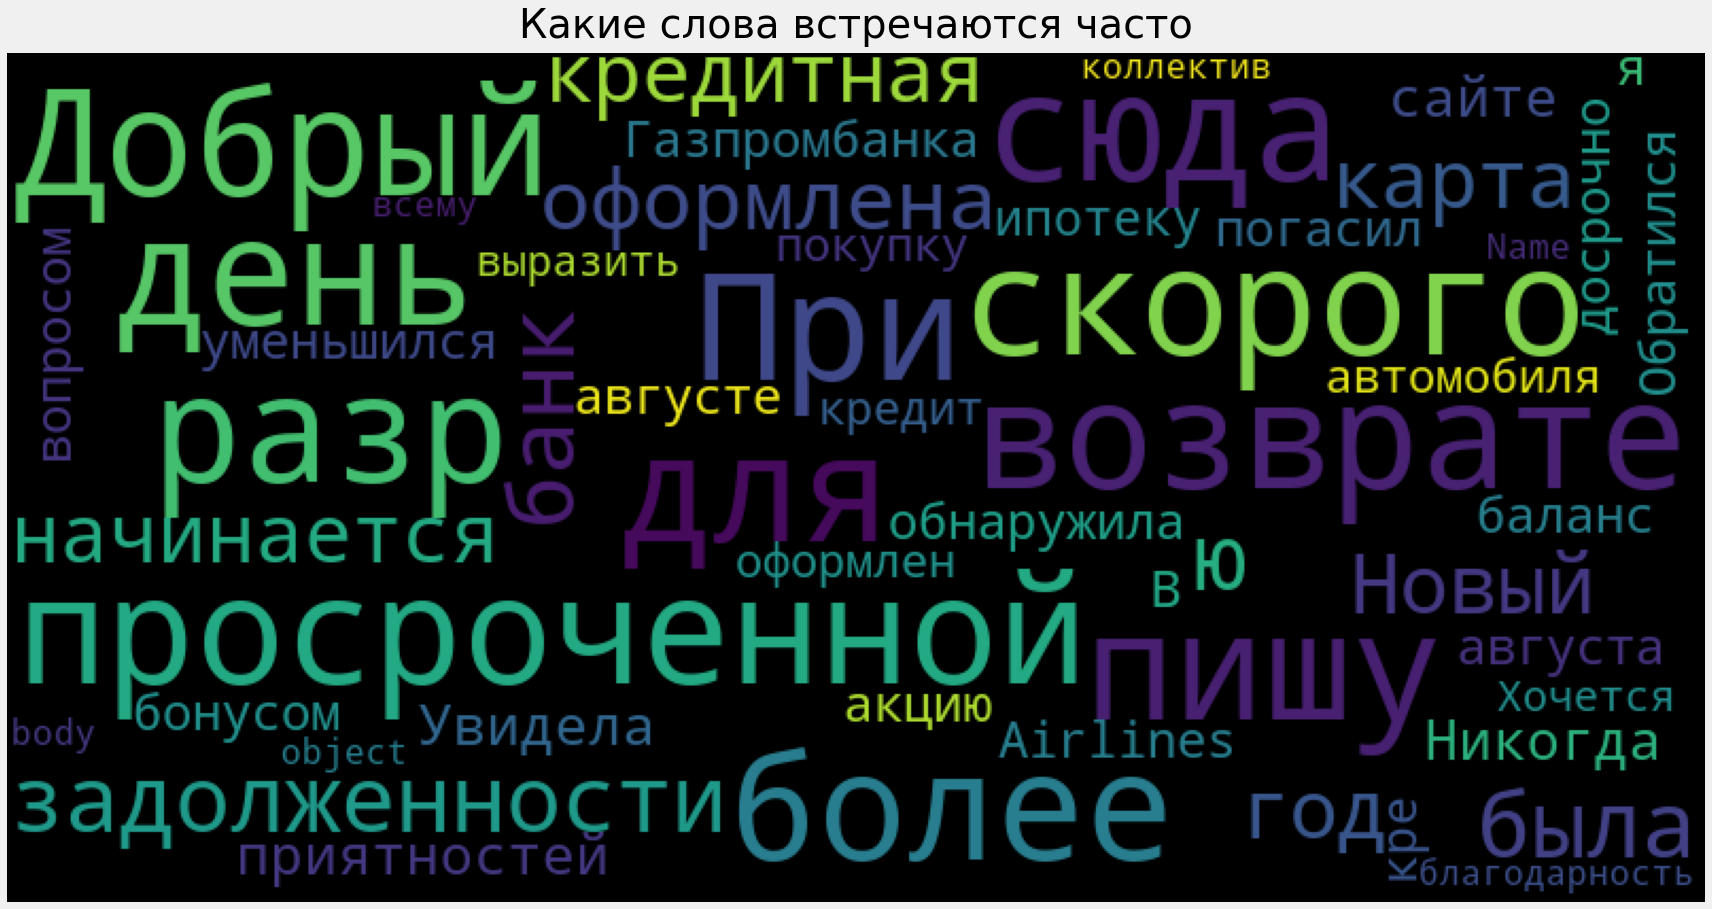

In [ ]:
%%time

def plot_wordcloud(text, mask=None, max_words=200, max_font_size=70, figure_size=(24.0,16.0), 
                   title = None, title_size=40, image_color=False):
    stopwords = set(STOPWORDS)
    more_stopwords = {'С', 'на', 'по', 'что', 'dtype', 'Length', 'Unknown'}
    stopwords = stopwords.union(more_stopwords)

    wordcloud = WordCloud(background_color='black',
                    stopwords = stopwords,
                    max_words = max_words,
                    max_font_size = max_font_size, 
                    random_state = 42,
                    width=800, 
                    height=400,
                    mask = mask)
    wordcloud.generate(str(text))
    
    plt.figure(figsize=figure_size)
    if image_color:
        image_colors = ImageColorGenerator(mask);
        plt.imshow(wordcloud.recolor(color_func=image_colors), interpolation="bilinear");
        plt.title(title, fontdict={'size': title_size,  
                                  'verticalalignment': 'bottom'})
    else:
        plt.imshow(wordcloud);
        plt.title(title, fontdict={'size': title_size, 'color': 'black', 
                                  'verticalalignment': 'bottom'})
    plt.axis('off');
    plt.tight_layout()  
    
plot_wordcloud(data["body"], title="Какие слова встречаются часто")

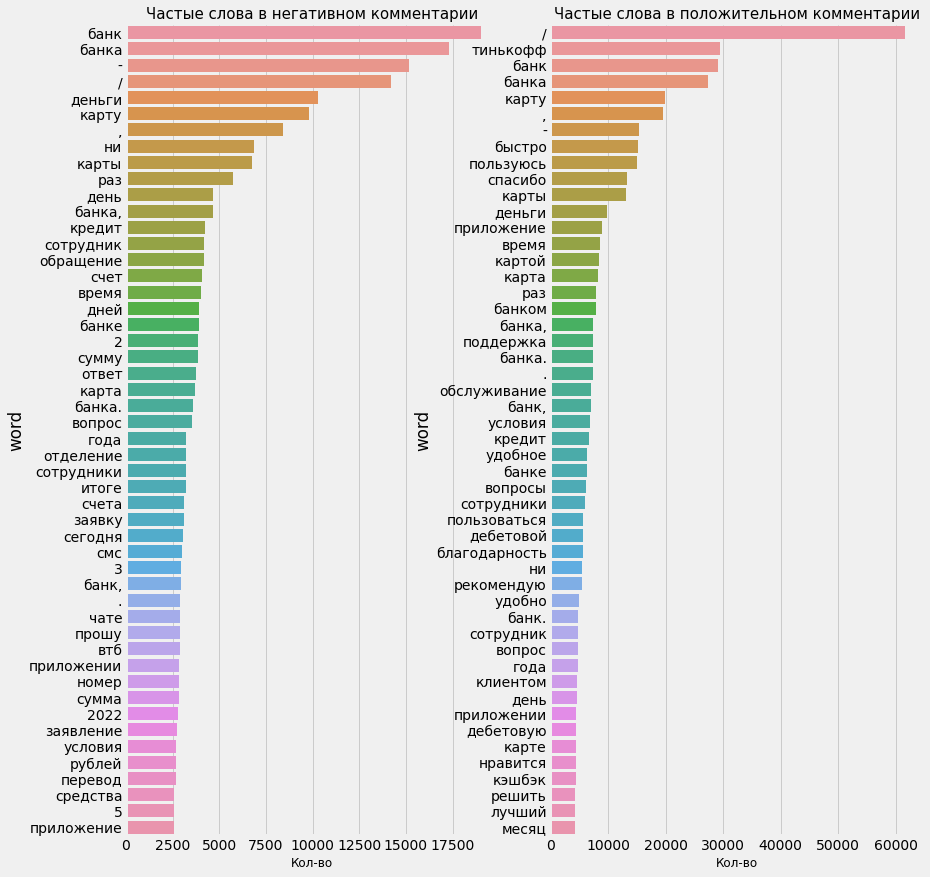

In [ ]:
from collections import defaultdict
train0 = data[data["Target"] == 0]
train1 = data[data["Target"] == 1]

def generate_ngrams(text, n_gram=1):
    
    token = [token for token in text.lower().split() if token != "" if token not in STOP_WORDS]
    ngrams = zip(*[token[i:] for i in range(n_gram)])
    return [" ".join(ngram) for ngram in ngrams]


freq_dict = defaultdict(int)
for sent in train0["body"]:
    for word in generate_ngrams(sent):
        freq_dict[word] += 1
fd_sorted0 = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted0.columns = ["word", "wordcount"]


freq_dict = defaultdict(int)
for sent in train1["body"]:
    for word in generate_ngrams(sent):
        freq_dict[word] += 1
fd_sorted1 = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted1.columns = ["word", "wordcount"]

fig, axes = plt.subplots(1, 2, figsize = (12, 12))
plt.tight_layout()
sns.despine()
for i in range(2):
    sns.barplot(x = "wordcount", y = "word", data = globals()["fd_sorted" + str(i)].iloc[:50, :], ax = axes[i])
    if (i==0):
      axes[i].set_xlabel('Кол-во', fontsize=12)
      axes[i].set_title(f"Частые слова в негативном комментарии", fontsize=15)
    else:
      axes[i].set_xlabel('Кол-во', fontsize=12)
      axes[i].set_title(f"Частые слова в положительном комментарии", fontsize=15)  

# NLP

Для решения данной проблемы я решил воспользоваться различными библиотеками, которые помогли преобразовать слова в числовой формат с наименьшей потерей смысла текста. Для этого мы очистим текст, после мы посчитаем кол-во слов ( в среднем в каждем обзоре ) и дальше займёмся тем, что начнём преобразовывать и параллельно делить нашу выборку. После всех делений, мы запихнём всё в лог регрессионную модель машинного обучения и проведём первичный анализ и точность нашей модели

Positive    71890
Negative    20842
Name: target, dtype: int64


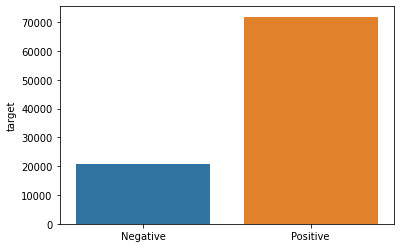

In [14]:
x=data['target'].value_counts()
print(x)
sns.barplot(x.index,x)

In [15]:
#1. среднее кол-во слов в позитивном и негативном комментарии
data['word_count'] = data['body'].apply(lambda x: len(str(x).split()))
print(data[data['target']=="Positive"]['word_count'].mean()) 
print(data[data['target']=="Negative"]['word_count'].mean()) 
print()

#2. среднее кол-во букв в позитивном и негативном комментарии
data['char_count'] = data['body'].apply(lambda x: len(str(x)))
print(data[data['target']=="Positive"]['char_count'].mean()) 
print(data[data['target']=="Negative"]['char_count'].mean()) 
print()

#3. кол-во уникальных слов в позитивном и негативном комментарии
data['unique_word_count'] = data['body'].apply(lambda x: len(set(str(x).split())))
print(data[data['target']=="Positive"]['unique_word_count'].mean())
print(data[data['target']=="Negative"]['unique_word_count'].mean())

71.12533036583669
164.78941560310912

482.42852969814993
1080.5107475290279

61.73630546668522
125.54121485462048


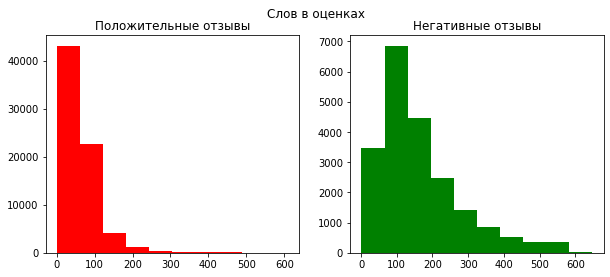

In [16]:
# Тут мы считаем кол-во слов в "негативном поле" и "позитивном"
# Как мы видим, положительные отзывы очень многословны, в отличие от негативных...
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,4))
train_words=data[data['target']=="Positive"]['word_count']
ax1.hist(train_words,color='red')
ax1.set_title('Положительные отзывы')
train_words=data[data['target']=="Negative"]['word_count']
ax2.hist(train_words,color='green')
ax2.set_title('Негативные отзывы')
fig.suptitle('Слов в оценках')
plt.show()

In [17]:
#Тут мы уже начинаем наш первичное преобразование
text = "П Р и ветеет!!,,??!! Эро тестовое сообщение ДЛЯ пРоВер Ки <br>    работы механизма механизмом обработки тек-ста и сообщений ! Знали ли вы что знала она сколько он идёт и шла туда приложение приложении"

#Можно сказать, что некоторые из этих функций мы уже выполнили выше,
# но на самом деле датасет довольно-таки большой и за некоторыми значениями 
# банально сложно уследить, поэтому и проводится повторная проверка
def preprocess(text):
    text = text.lower() 
    text=text.strip()  
    text=re.compile('<.*?>').sub('', text) 
    text = re.compile('[%s]' % re.escape(string.punctuation)).sub(' ', text) 
    text = re.sub('\s+', ' ', text)  
    text = re.sub(r'\[[0-9]*\]',' ',text) 
    text=re.sub(r'[^\w\s]', '', str(text).lower().strip())
    text = re.sub(r'\d',' ',text) 
    text = re.sub(r'\s+',' ',text) 
    return text

text=preprocess(text)
print(text)

п р и ветеет эро тестовое сообщение для провер ки работы механизма механизмом обработки тек ста и сообщений знали ли вы что знала она сколько он идёт и шла туда приложение приложении


In [18]:

# В данном месте мы проводим очистку от стоп слов, используя библиотеку стоп слов на русском
def stopword(string):
    a= [i for i in string.split() if i not in stopwords.words('russian')]
    return ' '.join(a)

text=stopword(text)
print(text)

 
# Здесь мы используем стеммер с ру словарем
def stemming(string):
    snow = SnowballStemmer('russian')
    a=[snow.stem(i) for i in word_tokenize(string) ]
    return " ".join(a)
text=stemming(text)
print(text)


#Тут мы уже проводим лемматизацию нашего текста
wl = WordNetLemmatizer()

def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN


# Здесь же мы токенезируем предложения
def lemmatizer(string):
    wl = WordNetLemmatizer()
    word_pos_tags = nltk.pos_tag(word_tokenize(string)) # получить тег позиции
    a=[wl.lemmatize(tag[0], get_wordnet_pos(tag[1])) for idx, tag in enumerate(word_pos_tags)] 
    return " ".join(a)

text = lemmatizer(text)
print(text)

п р ветеет эро тестовое сообщение провер ки работы механизма механизмом обработки тек ста сообщений знали знала сколько идёт шла туда приложение приложении
п р ветеет эр тестов сообщен провер ки работ механизм механизм обработк тек ста сообщен знал знал скольк идет шла туд приложен приложен
п р ветеет эр тестов сообщен провер ки работ механизм механизм обработк тек ста сообщен знал знал скольк идет шла туд приложен приложен


In [19]:
#На данном этапе мы проводим финальный препроцессинг, после чего начнём работать уже с совершенно иными данными
%%time
def finalpreprocess(string):
    return lemmatizer(stemming(stopword(preprocess(string))))

data['clean_text'] = data['body'].apply(lambda x: finalpreprocess(x))
data['clean_title'] = data['title'].apply(lambda x: finalpreprocess(x))


df_train=data.drop(columns=['word_count','char_count','unique_word_count'])
df_train.head()

CPU times: user 28min 59s, sys: 2min 11s, total: 31min 11s
Wall time: 32min 4s


,body,title,rating,bank_name,date,month,week,target,Target,clean_text,clean_title
0,Добрый день пишу сюда для более скорого разр...,Заблокировали средства,1,Еком Банк,2023-01-03 12:46:11,1,1,Negative,0,добр ден пиш сюд скор разрешен вопрос пополн ю...,заблокирова средств
1,"При возврате просроченной задолженности, банк...",Возврат просроченной задолженномти,1,Тинькофф Банк,2023-01-03 12:31:46,1,1,Negative,0,возврат просрочен задолжен банк звон трет лиц ...,возврат просрочен задолженномт
2,"07.09.22 ю была оформлена кредитная карта ""12...","Ошибочное начисление комиссии, затягивание про...",1,Банк Открытие,2023-01-03 12:23:11,1,1,Negative,0,ю оформл кредитн карт дне банк открыт погашен ...,ошибочн начислен комисс затягиван процесс
3,Новый год начинается с приятностей) Никогда ...,Клиентоориентиванность 10 из 10,5,Тинькофф Банк,2023-01-03 12:16:07,1,1,Positive,1,нов год начина приятност понима люд котор крит...,клиентоориентиван
4,Увидела на сайте Газпромбанка акцию с бонусом...,Как Газпромбанк обманывает клиентов с акционны...,1,Газпромбанк,2023-01-03 12:12:36,1,1,Negative,0,увидел сайт газпромбанк акц бонус кредитн карт...,газпромбанк обманыва клиент акцион карт


### Ещё раз визуализируем наши обновлённые слова !

CPU times: user 421 ms, sys: 41.8 ms, total: 463 ms
Wall time: 497 ms


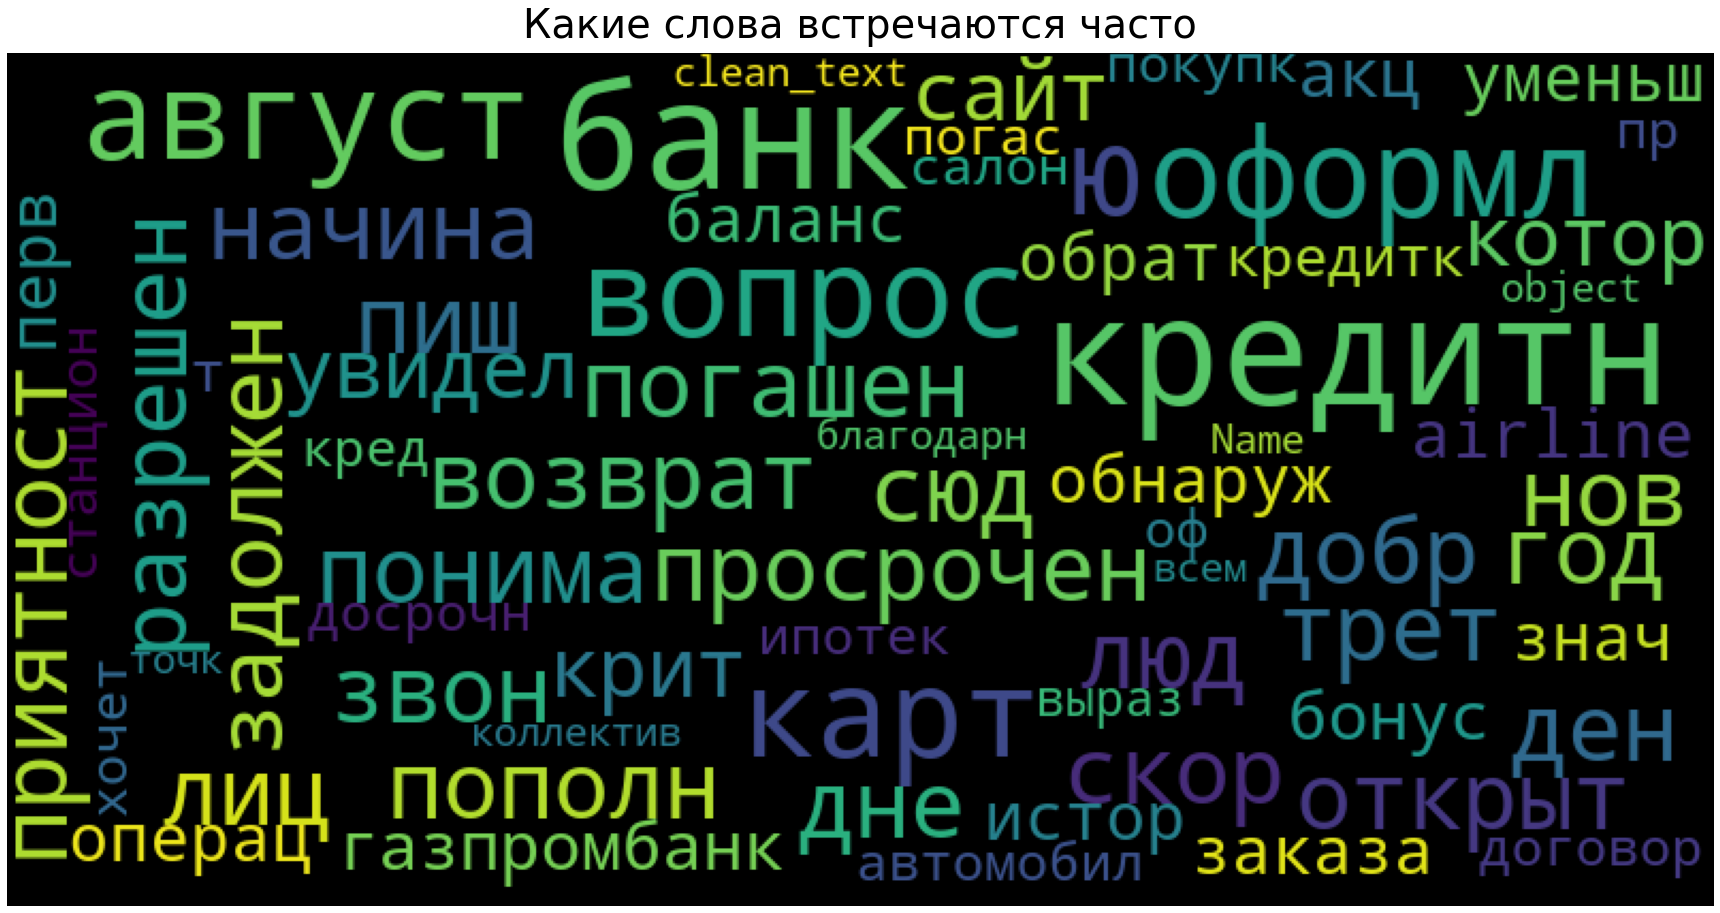

In [20]:
%%time

import spacy # I'll be making use of spacy for text preprocessing
from spacy.lang.ru.stop_words import STOP_WORDS
from spacy.lang.ru import Russian
import string, re
# from spacy.lang.en.stop_words import STOP_WORDS
# from spacy.lang.en import English, Russian



from wordcloud import WordCloud, STOPWORDS
def plot_wordcloud(text, mask=None, max_words=200, max_font_size=70, figure_size=(24.0,16.0), 
                   title = None, title_size=40, image_color=False):
    stopwords = set(STOPWORDS)
    more_stopwords = {'С', 'на', 'по', 'что', 'dtype', 'Length', 'Unknown'}
    stopwords = stopwords.union(more_stopwords)

    wordcloud = WordCloud(background_color='black',
                    stopwords = stopwords,
                    max_words = max_words,
                    max_font_size = max_font_size, 
                    random_state = 42,
                    width=800, 
                    height=400,
                    mask = mask)
    wordcloud.generate(str(text))
    
    plt.figure(figsize=figure_size)
    if image_color:
        image_colors = ImageColorGenerator(mask);
        plt.imshow(wordcloud.recolor(color_func=image_colors), interpolation="bilinear");
        plt.title(title, fontdict={'size': title_size,  
                                  'verticalalignment': 'bottom'})
    else:
        plt.imshow(wordcloud);
        plt.title(title, fontdict={'size': title_size, 'color': 'black', 
                                  'verticalalignment': 'bottom'})
    plt.axis('off');
    plt.tight_layout()  
    
plot_wordcloud(data["clean_text"], title="Какие слова встречаются часто")

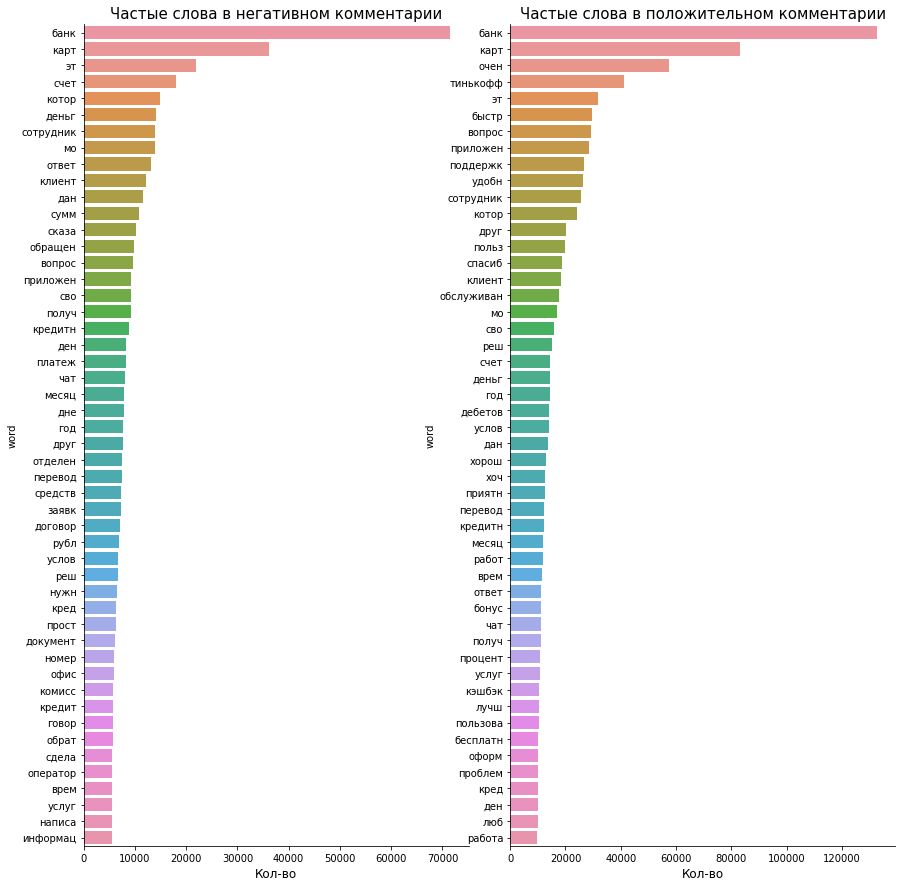

In [21]:
from collections import defaultdict
train0 = data[data["Target"] == 0]
train1 = data[data["Target"] == 1]

def generate_ngrams(text, n_gram=1):
    
    token = [token for token in text.lower().split() if token != "" if token not in STOP_WORDS]
    ngrams = zip(*[token[i:] for i in range(n_gram)])
    return [" ".join(ngram) for ngram in ngrams]


freq_dict = defaultdict(int)
for sent in train0["clean_text"]:
    for word in generate_ngrams(sent):
        freq_dict[word] += 1
fd_sorted0 = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted0.columns = ["word", "wordcount"]


freq_dict = defaultdict(int)
for sent in train1["clean_text"]:
    for word in generate_ngrams(sent):
        freq_dict[word] += 1
fd_sorted1 = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted1.columns = ["word", "wordcount"]

fig, axes = plt.subplots(1, 2, figsize = (12, 12))
plt.tight_layout()
sns.despine()
for i in range(2):
    sns.barplot(x = "wordcount", y = "word", data = globals()["fd_sorted" + str(i)].iloc[:50, :], ax = axes[i])
    if (i==0):
      axes[i].set_xlabel('Кол-во', fontsize=12)
      axes[i].set_title(f"Частые слова в негативном комментарии", fontsize=15)
    else:
      axes[i].set_xlabel('Кол-во', fontsize=12)
      axes[i].set_title(f"Частые слова в положительном комментарии", fontsize=15)  

## Подготовка к машинному обучению

In [22]:
%%time
gc.collect()
# здесь words_f должен быть списком, содержащим слова из каждого документа. скажем, 1-я строка списка - это слова из 1-го документа / предложения
# длина words_f - это количество документов/предложений в вашем наборе данных
df_train['clean_text_tok']=[nltk.word_tokenize(i) for i in df_train['clean_text']] #Превращаем наше чистое предложение в токенезированное
model = Word2Vec(df_train['clean_text_tok'],min_count=1)  

CPU times: user 2min 16s, sys: 2.34 s, total: 2min 18s
Wall time: 1min 36s


In [23]:
w2v = dict(zip(model.wv.index2word, model.wv.syn0))  #Комбинация слова и вектора

In [24]:
#для преобразования предложения в векторы/числа из результатов word vectors с помощью Word2Vec
class MeanEmbeddingVectorizer(object):
    def __init__(self, word2vec):
        self.word2vec = word2vec
        # if a text is empty we should return a vector of zeros
        # with the same dimensionality as all the other vectors
        self.dim = len(next(iter(word2vec.values())))

    def fit(self, X, y):
        return self

    def transform(self, X):
        return np.array([
            np.mean([self.word2vec[w] for w in words if w in self.word2vec]
                    or [np.zeros(self.dim)], axis=0)
            for words in X
        ])

In [25]:
#Разделение выборки на тестовую и обучающуюся
 
X=df_train["clean_text"]
y=df_train["Target"]
X_train, X_val, y_train, y_val = train_test_split(X,
                                                  y,
                                                  test_size=0.3,
                                                  shuffle=True,
                                                  stratify=df_train['Target'])
X_train_tok= [nltk.word_tokenize(i) for i in X_train]  #for word2vec
X_val_tok= [nltk.word_tokenize(i) for i in X_val]      #for word2vec

gc.collect()

0

In [26]:
X_tok= [nltk.word_tokenize(i) for i in X]  

In [27]:
tfidf_vectorizer = TfidfVectorizer(use_idf=True)
X_vectors_tfidf = tfidf_vectorizer.fit_transform(X)

In [28]:
modelw = MeanEmbeddingVectorizer(w2v)
X_vectors_w2v = modelw.transform(X_tok)

In [29]:
X_vectors_w2v.shape,X_vectors_tfidf, y.shape

((92732, 100), <92732x63837 sparse matrix of type '<class 'numpy.float64'>'
 	with 4357430 stored elements in Compressed Sparse Row format>, (92732,))

In [30]:

tfidf_vectorizer = TfidfVectorizer(use_idf=True)
X_train_vectors_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_val_vectors_tfidf = tfidf_vectorizer.transform(X_val)

In [31]:
# Преобразуйте x_train в вектор, поскольку модель может работать только с числами, а не со словами - Fit and transform
tfidf_vectorizer = TfidfVectorizer(use_idf=True)
X_train_vectors_tfidf = tfidf_vectorizer.fit_transform(X_train) 
X_val_vectors_tfidf = tfidf_vectorizer.transform(X_val) # Здесь я превращаю весь мой текст в вектора

In [32]:
#Word2vec
#И тут я тоже преобразовываю всё это в вектора более нормального вида
modelw = MeanEmbeddingVectorizer(w2v)
X_train_vectors_w2v = modelw.transform(X_train_tok)
X_val_vectors_w2v = modelw.transform(X_val_tok)

In [33]:
y_train.shape

(64912,)

In [34]:
X_train_vectors_tfidf.shape

(64912, 52273)

In [35]:
#Используем лог регрессию для классификации !

log_reg=LogisticRegression(solver = 'liblinear', C=10, penalty = 'l2')
log_reg.fit(X_train_vectors_tfidf, y_train)  #model

#Predict y value for test dataset
y_predict_val = log_reg.predict(X_val_vectors_tfidf)
y_prob_val = log_reg.predict_proba(X_val_vectors_tfidf)[:,1]

y_predict_train = log_reg.predict(X_train_vectors_tfidf)
y_prob_train = log_reg.predict_proba(X_train_vectors_tfidf)[:,1]

In [36]:
print(classification_report(y_val,y_predict_val))
print('Confusion Matrix:',sklearn.metrics.confusion_matrix( y_val,y_predict_val, labels=log_reg.classes_))
cm = sklearn.metrics.confusion_matrix( y_val,y_predict_val, labels=log_reg.classes_)

              precision    recall  f1-score   support

           0       0.92      0.94      0.93      6253
           1       0.98      0.98      0.98     21567

    accuracy                           0.97     27820
   macro avg       0.95      0.96      0.96     27820
weighted avg       0.97      0.97      0.97     27820

Confusion Matrix: [[ 5887   366]
 [  491 21076]]


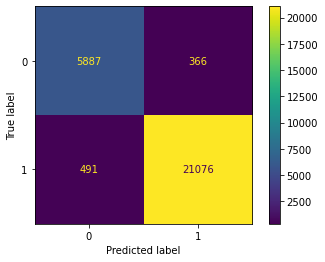

In [37]:
from sklearn.metrics import ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=log_reg.classes_)
disp.plot()

plt.show()

In [38]:
fpr, tpr, thresholds = roc_curve(y_val, y_prob_val)
roc_auc = auc(fpr, tpr)
print('AUC:', roc_auc)  

AUC: 0.9910376918091696


In [39]:
print(classification_report(y_train,y_predict_train))
print('Confusion Matrix:',sklearn.metrics.confusion_matrix(y_train, y_predict_train))
cm = sklearn.metrics.confusion_matrix( y_train, y_predict_train, labels=log_reg.classes_)

              precision    recall  f1-score   support

           0       0.96      0.98      0.97     14589
           1       1.00      0.99      0.99     50323

    accuracy                           0.99     64912
   macro avg       0.98      0.99      0.98     64912
weighted avg       0.99      0.99      0.99     64912

Confusion Matrix: [[14365   224]
 [  612 49711]]


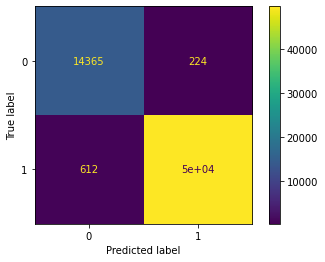

In [40]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=log_reg.classes_)
disp.plot()

plt.show()

In [41]:
fpr, tpr, thresholds = roc_curve(y_train, y_prob_train)
roc_auc = auc(fpr, tpr)
print('AUC:', roc_auc)  
gc.collect()

AUC: 0.9980948182697822


3806

# Улучшение с помощью Optuna и используемые метрики

Какие метрики были выбраны:

Roc Auc

Average Prec Score

BalancedAccuracy

Основной упор был сделан на roc auc так как он хорошо справляется с бинарной классификацией (которая у нас тут и имеется) и он может нормально ( с некоторыми ограничениями ) справляться на несбалансированном датасете.  Так или иначе, он свою задачу делал на ура и, с использованием данной метрики, он показал хороший результат (при использовании модели лог регрессии) 

PRAuc тоже хорошо справляется, и иногда его советуют использовать больше чем roc auc. В своей основе эта метрика суммирует кривую точности как средневзвешенное значение точности, достигнутой при каждом пределе, при этом в качестве веса используется увеличение оценки по сравнению с предыдущим пределом.

BalancedAccuracy тут шли метания между выбором F1 score и данной метрикой. В итоге, я склонился больше в сторону balancedaccuracy по причине того, что она одинаково смотрит на негативные и позитивные значения, тогда же как F1 смотрит больше в сторону позитивных (обделяет другое значение) 

## Версия 1

In [ ]:
def objective(trial,data=X_train_vectors_w2v,target=y_train):
    train_x, test_x, train_y, test_y = train_test_split(data, target, test_size=0.35,random_state=42, stratify=target)
    
    
    cv_rf= StratifiedKFold(n_splits=10)
    param = {
        'penalty': trial.suggest_categorical('penalty', ['l1', 'l2', 'elasticnet', "none"]),
        'tol': trial.suggest_float('tol', 1e-7, 1.0),
        'C': trial.suggest_float('C', 1, 12.0),
        'fit_intercept': trial.suggest_categorical('fit_intercept', [True,False]),
        'max_iter':trial.suggest_int('max_iter', 100, 10000),
        'n_jobs':-1,        
    }
    
    if param['penalty'] in ['l2',"none"]: #
      param['solver']= trial.suggest_categorical('solver', ["lbfgs","newton-cg",'saga',"sag"]) #,"newton-cholesky"
    elif param['penalty'] in ['elasticnet']:
      param['solver']= trial.suggest_categorical('solver_el', ["saga"])
      param['l1_ratio']= trial.suggest_float('l1_ratio' , 0, 1)
    elif param['penalty'] == "l1":
      param['solver']= trial.suggest_categorical('solver_l', ["liblinear"])

    if param['penalty'] == 'l2' and param['solver']=="liblinear":
      param['dual'] = trial.suggest_categorical('dual', [True,False])

    print(param)
    model = LogisticRegression(**param)  
    model.fit(train_x,train_y.astype('int32'))
    
    preds = model.predict(test_x)

    y_probab = model.predict_proba(test_x)[:,1] 

    print(sklearn.metrics.roc_auc_score(test_y, y_probab))

    joblib.dump(study, '/content/drive/MyDrive/Colab Notebooks/tests/log_reg_sber.pkl')
    return (cross_val_score(model, test_x, test_y, cv = cv_rf, scoring = "roc_auc")).mean()
    

In [ ]:
def logging_callback(study, frozen_trial):
    previous_best_value = study.user_attrs.get("previous_best_value", None)
    if previous_best_value != study.best_value:
        study.set_user_attr("previous_best_value", study.best_value)
        print(
            "\nWarning\nTrial {} finished with best value: {} and parameters: {}.\n ".format(
            frozen_trial.number,
            frozen_trial.value,
            frozen_trial.params,
            )
        )

In [ ]:
%%time 
gc.collect()

if os.path.isfile('/content/drive/MyDrive/Colab Notebooks/tests/log_reg_sber.pkl'):
  print("Found file !")
  study = joblib.load('/content/drive/MyDrive/Colab Notebooks/tests/log_reg_sber.pkl')
else:
    sampler = optuna.samplers.TPESampler(multivariate=True, warn_independent_sampling=False)
    study = optuna.create_study(direction='maximize', load_if_exists=True,sampler=sampler)

study.optimize(objective, n_trials=1500, gc_after_trial=True,
              show_progress_bar=True, n_jobs=-1, callbacks=[logging_callback])
joblib.dump(study, '/content/drive/MyDrive/Colab Notebooks/tests/log_reg_sber.pkl')

In [ ]:
study = joblib.load('/content/drive/MyDrive/Colab Notebooks/tests/log_reg_sber.pkl')

In [ ]:
print('Number of finished trials:', len(study.  trials))
print('Best trial:', study.best_trial.params)

Number of finished trials: 1500
Best trial: {'penalty': 'l2', 'tol': 0.08391286776243824, 'C': 1.067197249820532, 'fit_intercept': True, 'max_iter': 3338, 'solver': 'sag'}


In [ ]:
Best_trial = study.best_trial.params
#Best_trial["n_estimators"], Best_trial["tree_method"] = 10000, 'gpu_hist'
Best_trial

{'penalty': 'l2',
 'tol': 0.08391286776243824,
 'C': 1.067197249820532,
 'fit_intercept': True,
 'max_iter': 3338,
 'solver': 'sag'}

In [ ]:
study.best_trial.value

0.9874691134000706

In [ ]:
optuna.visualization.plot_optimization_history(study)

In [ ]:
optuna.visualization.plot_slice(study)

In [ ]:
optuna.visualization.plot_edf(study)

In [ ]:
optuna.visualization.plot_param_importances(study)

In [ ]:
cv_rf= StratifiedKFold(n_splits=5)
best_model = LogisticRegression(**study.best_params,
                                ).fit(X_train_vectors_w2v,y_train)

res = cross_val_score(best_model, X_val_vectors_w2v, y_val, cv = cv_rf, scoring = 'roc_auc')
print(f'Best value cross val: {study.best_value} \nTest score:  {res.mean()}' )

Best value cross val: 0.9874691134000706 
Test score:  0.9892578800404366


## Версия 2

In [42]:
def objective(trial,data=X_vectors_w2v,target=y):
    train_x, test_x, train_y, test_y = train_test_split(data, target, test_size=0.35,random_state=42, stratify=target)
    
    
    cv_rf= StratifiedKFold(n_splits=10)
    param = {
        'penalty': trial.suggest_categorical('penalty', ['l1', 'l2', 'elasticnet', "none"]),
        'tol': trial.suggest_float('tol', 1e-7, 1.0),
        'C': trial.suggest_float('C', 1, 12.0),
        'fit_intercept': trial.suggest_categorical('fit_intercept', [True,False]),
        'max_iter':trial.suggest_int('max_iter', 100, 10000),
        'n_jobs':-1,        
    }
    
    if param['penalty'] in ['l2',"none"]: #
      param['solver']= trial.suggest_categorical('solver', ["lbfgs","newton-cg",'saga',"sag"]) #,"newton-cholesky"
    elif param['penalty'] in ['elasticnet']:
      param['solver']= trial.suggest_categorical('solver_el', ["saga"])
      param['l1_ratio']= trial.suggest_float('l1_ratio' , 0, 1)
    elif param['penalty'] == "l1":
      param['solver']= trial.suggest_categorical('solver_l', ["liblinear"])

    if param['penalty'] == 'l2' and param['solver']=="liblinear":
      param['dual'] = trial.suggest_categorical('dual', [True,False])

    print(param)
    model = LogisticRegression(**param)  
    model.fit(train_x,train_y.astype('int32'))
    
    preds = model.predict(test_x)

    y_probab = model.predict_proba(test_x)[:,1] 

    print(sklearn.metrics.roc_auc_score(test_y, y_probab))

    joblib.dump(study, '/content/drive/MyDrive/Colab Notebooks/tests/log_reg_sber_result.pkl')
    return (cross_val_score(model, test_x, test_y, cv = cv_rf, scoring = "roc_auc")).mean()


In [43]:
def logging_callback(study, frozen_trial):
    previous_best_value = study.user_attrs.get("previous_best_value", None)
    if previous_best_value != study.best_value:
        study.set_user_attr("previous_best_value", study.best_value)
        print(
            "\nWarning\nTrial {} finished with best value: {} and parameters: {}.\n ".format(
            frozen_trial.number,
            frozen_trial.value,
            frozen_trial.params,
            )
        )

In [ ]:
%%time 
gc.collect()

if os.path.isfile('/content/drive/MyDrive/Colab Notebooks/tests/log_reg_sber_result.pkl'):
  print("Found file !")
  study = joblib.load('/content/drive/MyDrive/Colab Notebooks/tests/log_reg_sber_result.pkl')
else:
    sampler = optuna.samplers.TPESampler(multivariate=True, warn_independent_sampling=False)
    study = optuna.create_study(direction='maximize', load_if_exists=True,sampler=sampler)

study.optimize(objective, n_trials=1500, gc_after_trial=True,
              show_progress_bar=True, n_jobs=-1, callbacks=[logging_callback])
joblib.dump(study, '/content/drive/MyDrive/Colab Notebooks/tests/log_reg_sber_result.pkl')

In [ ]:
study = joblib.load('/content/drive/MyDrive/Colab Notebooks/tests/log_reg_sber_result.pkl')

In [ ]:
print('Number of finished trials:', len(study.  trials))
print('Best trial:', study.best_trial.params)

Number of finished trials: 1500
Best trial: {'penalty': 'elasticnet', 'tol': 0.01612836206749085, 'C': 3.463880882958034, 'fit_intercept': True, 'max_iter': 2374, 'solver_el': 'saga', 'l1_ratio': 0.000803699038061767}


In [ ]:
Best_trial = study.best_trial.params
Best_trial

{'penalty': 'elasticnet',
 'tol': 0.01612836206749085,
 'C': 3.463880882958034,
 'fit_intercept': True,
 'max_iter': 2374,
 'solver_el': 'saga',
 'l1_ratio': 0.000803699038061767}

In [ ]:
study.best_trial.value

0.988745260448856

In [ ]:
optuna.visualization.plot_optimization_history(study)

In [ ]:
optuna.visualization.plot_parallel_coordinate(study)

[W 2023-01-16 12:43:13,231] Your study has only completed trials with missing parameters.


In [ ]:
optuna.visualization.plot_slice(study)

In [ ]:
optuna.visualization.plot_edf(study)

In [ ]:
optuna.visualization.plot_param_importances(study)

In [ ]:
best_params = study.best_params

In [ ]:
if (best_params['solver_el'] == 'saga'):
    best_params['solver'] = best_params['solver_el']
    del best_params['solver_el']
    print(best_params)

best_params

{'penalty': 'elasticnet', 'tol': 0.01612836206749085, 'C': 3.463880882958034, 'fit_intercept': True, 'max_iter': 2374, 'l1_ratio': 0.000803699038061767, 'solver': 'saga'}


{'penalty': 'elasticnet',
 'tol': 0.01612836206749085,
 'C': 3.463880882958034,
 'fit_intercept': True,
 'max_iter': 2374,
 'l1_ratio': 0.000803699038061767,
 'solver': 'saga'}

In [ ]:
cv_rf= StratifiedKFold(n_splits=5)
best_model = LogisticRegression(**best_params,
                                ).fit(X_vectors_w2v,y)

res = cross_val_score(best_model, X_val_vectors_w2v, y_val, cv = cv_rf, scoring = 'roc_auc')
print(f'Best value cross val: {study.best_value} \nTest score:  {res.mean()}' )

Best value cross val: 0.988745260448856 
Test score:  0.989318287032949


Как мы видим, точность довольно-таки высокая и можно дальше продолжать с этим работать

## Теперь давайте проверим какая будет точность при использовании модели LightGBM

In [45]:
def objective(trial,data=X_vectors_w2v,target=y):
    train_x, test_x, train_y, test_y = train_test_split(data, target, test_size=0.35,random_state=42, stratify=target)
    
    cv_rf= StratifiedKFold(n_splits=10)
    param = {
      "objective": trial.suggest_categorical("objective",["binary","cross_entropy"]),
      "n_estimators": trial.suggest_int("n_estimators",2000, 7000),
      "metric": ['auc','average_precision'],
      "num_threads" : 2,
      'learning_rate': trial.suggest_float('learning_rate', 1e-7,1),
      "num_leaves": trial.suggest_int("num_leaves", 40, 4000, step=20),
      "max_depth": trial.suggest_int("max_depth", 3, 10),
      "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 50, 100, step=1),
      "lambda_l1": trial.suggest_int("lambda_l1", 0, 100, step=1),
      "lambda_l2": trial.suggest_int("lambda_l2", 0, 100, step=1),
      'min_child_weight': trial.suggest_float('min_child_samples', 0.1,round(X.shape[0]/1000,1), step = 0.1),
      "bagging_fraction": trial.suggest_float("bagging_fraction", 0.2, 0.9, step=0.1),
      "bagging_freq": trial.suggest_categorical("bagging_freq", [1]),
      "feature_fraction": trial.suggest_float("feature_fraction", 0.2, 0.9, step=0.1
      ),

    }

    model = lgbm.LGBMClassifier(**param,random_state = 42)
    model.fit(train_x,train_y,eval_set=[(test_x,test_y)],early_stopping_rounds=500,verbose=False)
    preds = model.predict(test_x)

    y_probab = model.predict_proba(test_x)[:,1]

    print(sklearn.metrics.roc_auc_score(test_y, y_probab))

    joblib.dump(study, '/content/drive/MyDrive/Colab Notebooks/tests/for_lgbm_checkpoints/lgbm_sber_result.pkl')
    if (param['metric'] == "average_precision"):
      return (cross_val_score(model, train_x, train_y, cv=cv_rf, scoring='average_precision', n_jobs=-1)).mean()
    else:
      return (cross_val_score(model, test_x, test_y, cv = cv_rf, scoring = "roc_auc", n_jobs=-1)).mean()
  

In [46]:
def logging_callback(study, frozen_trial):
    previous_best_value = study.user_attrs.get("previous_best_value", None)
    if previous_best_value != study.best_value:
        study.set_user_attr("previous_best_value", study.best_value)
        print(
            "\nWarning\nTrial {} finished with best value: {} and parameters: {}.\n ".format(
            frozen_trial.number,
            frozen_trial.value,
            frozen_trial.params,
            )
        )

In [47]:
%%time 
gc.collect()

if os.path.isfile('/content/drive/MyDrive/Colab Notebooks/tests/for_lgbm_checkpoints/lgbm_sber_result.pkl'):
  print("Found file !")
  study = joblib.load('/content/drive/MyDrive/Colab Notebooks/tests/for_lgbm_checkpoints/lgbm_sber_result.pkl')
else:
    sampler = optuna.samplers.TPESampler(multivariate=True, warn_independent_sampling=False)
    study = optuna.create_study(direction='maximize', load_if_exists=True,sampler=sampler,pruner=optuna.pruners.MedianPruner(n_warmup_steps=30,n_startup_trials=20))

study.optimize(objective, n_trials=1500, gc_after_trial=True,
              show_progress_bar=True, n_jobs=-1, callbacks=[logging_callback])
joblib.dump(study, '/content/drive/MyDrive/Colab Notebooks/tests/for_lgbm_checkpoints/lgbm_sber_result.pkl')

Found file !


  0%|          | 0/1500 [00:00<?, ?it/s]

0.9899373648885449
0.9901305040254844
[I 2023-01-17 17:13:25,883] Trial 75 finished with value: 0.9891322255362349 and parameters: {'objective': 'binary', 'n_estimators': 6558, 'learning_rate': 0.030239510517510816, 'num_leaves': 1500, 'max_depth': 5, 'min_data_in_leaf': 99, 'lambda_l1': 28, 'lambda_l2': 14, 'min_child_samples': 9.0, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.2}. Best is trial 43 with value: 0.989593382376105.
0.989994856632653
[I 2023-01-17 17:16:09,410] Trial 76 finished with value: 0.9896514081547896 and parameters: {'objective': 'cross_entropy', 'n_estimators': 6900, 'learning_rate': 0.07477035529939663, 'num_leaves': 1700, 'max_depth': 5, 'min_data_in_leaf': 95, 'lambda_l1': 12, 'lambda_l2': 42, 'min_child_samples': 7.5, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.2}. Best is trial 76 with value: 0.9896514081547896.

Warning
Trial 76 finished with best value: 0.9896514081547896 and parameters: {'objective': 'cross_entro

ERROR:concurrent.futures:exception calling callback for <Future at 0x7f5df3d127c0 state=finished raised ShutdownExecutorError>
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/joblib/externals/loky/_base.py", line 26, in _invoke_callbacks
    callback(self)
  File "/usr/local/lib/python3.8/dist-packages/joblib/parallel.py", line 385, in __call__
    self.parallel.dispatch_next()
  File "/usr/local/lib/python3.8/dist-packages/joblib/parallel.py", line 834, in dispatch_next
    if not self.dispatch_one_batch(self._original_iterator):
  File "/usr/local/lib/python3.8/dist-packages/joblib/parallel.py", line 901, in dispatch_one_batch
    self._dispatch(tasks)
  File "/usr/local/lib/python3.8/dist-packages/joblib/parallel.py", line 819, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  File "/usr/local/lib/python3.8/dist-packages/joblib/_parallel_backends.py", line 556, in apply_async
    future = self._workers.submit(SafeFunction(func))

[W 2023-01-17 23:12:06,481] Trial 102 failed because of the following error: WorkerInterrupt()
joblib.externals.loky.process_executor._RemoteTraceback: 
"""
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/joblib/_parallel_backends.py", line 620, in __call__
    return self.func(*args, **kwargs)
  File "/usr/local/lib/python3.8/dist-packages/joblib/parallel.py", line 288, in __call__
    return [func(*args, **kwargs)
  File "/usr/local/lib/python3.8/dist-packages/joblib/parallel.py", line 288, in <listcomp>
    return [func(*args, **kwargs)
  File "/usr/local/lib/python3.8/dist-packages/sklearn/utils/fixes.py", line 216, in __call__
    return self.function(*args, **kwargs)
  File "/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.8/dist-packages/lightgbm/sklearn.py", line 734, in fit
    super(LGBMClassifier, self).

KeyboardInterrupt: ignored

In [48]:
study = joblib.load('/content/drive/MyDrive/Colab Notebooks/tests/for_lgbm_checkpoints/lgbm_sber_result.pkl')

In [49]:
print('Number of finished trials:', len(study.  trials))
print('Best trial:', study.best_trial.params)

Number of finished trials: 104
Best trial: {'objective': 'binary', 'n_estimators': 2410, 'learning_rate': 0.07575666215596098, 'num_leaves': 3580, 'max_depth': 6, 'min_data_in_leaf': 79, 'lambda_l1': 4, 'lambda_l2': 63, 'min_child_samples': 1.4000000000000001, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.30000000000000004}


In [50]:
Best_trial = study.best_trial.params
Best_trial

{'objective': 'binary',
 'n_estimators': 2410,
 'learning_rate': 0.07575666215596098,
 'num_leaves': 3580,
 'max_depth': 6,
 'min_data_in_leaf': 79,
 'lambda_l1': 4,
 'lambda_l2': 63,
 'min_child_samples': 1.4000000000000001,
 'bagging_fraction': 0.8,
 'bagging_freq': 1,
 'feature_fraction': 0.30000000000000004}

In [51]:
study.best_trial.value

0.9898081051037539

In [52]:
optuna.visualization.plot_optimization_history(study)

In [53]:
optuna.visualization.plot_parallel_coordinate(study)

In [54]:
optuna.visualization.plot_slice(study)

In [55]:
optuna.visualization.plot_edf(study)

In [56]:
optuna.visualization.plot_param_importances(study)

In [58]:
cv_rf= StratifiedKFold(n_splits=5)
best_model = lgbm.LGBMClassifier(**study.best_params,
                                ).fit(X_vectors_w2v,y)

res = cross_val_score(best_model, X_val_vectors_w2v, y_val, cv = cv_rf, scoring = 'roc_auc')
print(f'Best value cross val: {study.best_value} \nTest score:  {res.mean()}' )

Best value cross val: 0.9898081051037539 
Test score:  0.9885432476154155


# Feature Selection

##KBest

Приведу пример, как можно улучшить качество модели, используя feature selection

In [ ]:
from sklearn.feature_selection import SelectKBest, chi2, f_classif


select_df = pd.DataFrame(columns = ['Train_score', 'KBest', 'Score_KBest', 'std', '%'])
for i in range(60, X_val_vectors_w2v.shape[1]+1):
  Xx = SelectKBest(f_classif, k=i).fit_transform(X_vectors_w2v, y)
  res = cross_val_score(best_model, Xx, y, cv = cv_rf, scoring = 'roc_auc')
  select_df = select_df.append({'Train_score': study.best_value,
                                'KBest': i, 'Score_KBest': res.mean(),
                                'std': res.std(),
                                '%': round(res.mean()*100/ study.best_value, 2)},
                               ignore_index=True)
select_df

,Train_score,KBest,Score_KBest,std,%
0,0.988745,60.0,0.987437,0.004367,99.87
1,0.988745,61.0,0.987436,0.004373,99.87
2,0.988745,62.0,0.987437,0.004377,99.87
3,0.988745,63.0,0.987489,0.004351,99.87
4,0.988745,64.0,0.987524,0.004331,99.88
5,0.988745,65.0,0.987653,0.004265,99.89
6,0.988745,66.0,0.987654,0.004265,99.89
7,0.988745,67.0,0.987660,0.004268,99.89
8,0.988745,68.0,0.987669,0.004253,99.89
9,0.988745,69.0,0.987666,0.004263,99.89


# Используем нейросети для классификации текста

Это уже совершенно другая часть, в которой я тоже постараюсь показать, как можно сделать классификацию текста с помощью нейронных сетей !

Заранее хочу предупредить, что точность по итогу вышла не самой плохой и может быть даже лучше, если приложить больше времени (а коллаб имеет свойство отключаться спустя некоторое время, что затрудняло это :) )

In [ ]:
train_df, val_df = train_test_split(data, test_size=0.3)
train_df.shape, val_df.shape

((64912, 14), (27820, 14))

In [ ]:
sample_row = data.iloc[16]
sample_comment = sample_row.body

In [ ]:
BERT_MODEL_NAME = 'bert-base-cased'
tokenizer = BertTokenizer.from_pretrained(BERT_MODEL_NAME)

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/213k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/436k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:
encoding = tokenizer.encode_plus(
  sample_comment,
  add_special_tokens=True,
  max_length=512,
  return_token_type_ids=False,
  padding="max_length",
  return_attention_mask=True,
  return_tensors='pt',
)

encoding.keys()

dict_keys(['input_ids', 'attention_mask'])

In [ ]:
encoding["input_ids"].shape, encoding["attention_mask"].shape

(torch.Size([1, 512]), torch.Size([1, 512]))

In [ ]:
token_counts = []

for _, row in train_df.iterrows():
  token_count = len(tokenizer.encode(
    row["body"],
    max_length=512,
    truncation=True
  ))
  token_counts.append(token_count)

(0.0, 512.0)

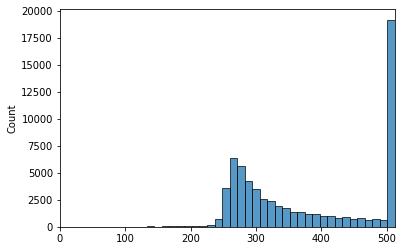

In [ ]:
sns.histplot(token_counts)
plt.xlim([0, 512])

In [ ]:
MAX_TOKEN_COUNT = 512

In [ ]:
class CommentBankDataset(Dataset): 

  #Тут идёт первичная инициализация нашего класса, который будет взаимодействовать с датасетом
  def __init__(
    self, 
    data: pd.DataFrame, 
    tokenizer: BertTokenizer, 
    max_token_len: int = 128
  ):
    # Здесь идёт объявление токенайзера, данных и максимального размера токена
    self.tokenizer = tokenizer
    self.data = data
    self.max_token_len = max_token_len
    
  # Тут мы строим различные методы для pytorch lightning
  def __len__(self):
    return len(self.data)

  def __getitem__(self, index: int):
    data_row = self.data.iloc[index]

    comment_text = data_row.body
    labels = data_row[LABEL_COLUMNS]

    encoding = self.tokenizer.encode_plus( # Это нужно для кодирования нашего текста
      comment_text,
      add_special_tokens=True,
      max_length=self.max_token_len,
      return_token_type_ids=False,
      padding="max_length",
      truncation=True,
      return_attention_mask=True,
      return_tensors='pt',
    )

    return dict(
      comment_text=comment_text,
      input_ids=encoding["input_ids"].flatten(),
      attention_mask=encoding["attention_mask"].flatten(),
      labels=torch.FloatTensor(labels)
    )

In [ ]:
LABEL_COLUMNS = [data.columns.tolist()[8]]
LABEL_COLUMNS

['Target']

In [ ]:
train_dataset = CommentBankDataset(
  train_df,
  tokenizer,
  max_token_len=MAX_TOKEN_COUNT
)

sample_item = train_dataset[0]
sample_item.keys()

dict_keys(['comment_text', 'input_ids', 'attention_mask', 'labels'])

In [ ]:
sample_item["labels"]

tensor([1.])

In [ ]:
sample_batch = next(iter(DataLoader(train_dataset, batch_size=8, num_workers=2)))
sample_batch["input_ids"].shape, sample_batch["attention_mask"].shape

(torch.Size([8, 512]), torch.Size([8, 512]))

In [ ]:
bert_model = BertModel.from_pretrained(BERT_MODEL_NAME, return_dict=True)

Downloading:   0%|          | 0.00/436M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
class BankRatingDataModule(pl.LightningDataModule):

  # Здесь идёт модуль для оценки наших оценок :)
  # Сперва инициализация
  def __init__(self, train_df, test_df, tokenizer, batch_size=8, max_token_len=128):
    super().__init__()
    self.batch_size = batch_size
    self.train_df = train_df
    self.test_df = test_df
    self.tokenizer = tokenizer
    self.max_token_len = max_token_len

  #Далее идёт подготовка некоторых данных
  def setup(self, stage=None):
    self.train_dataset = CommentBankDataset(
      self.train_df,
      self.tokenizer,
      self.max_token_len
    )

    #Так как мы будем тестировать нашу оценку, стоит прикрутить и отдельный модель для тестового датафрейма
    self.test_dataset = CommentBankDataset(
      self.test_df,
      self.tokenizer,
      self.max_token_len
    )

  # Здесь мы загружаем обучающий даталоудер
  def train_dataloader(self):
    return DataLoader(
      self.train_dataset,
      batch_size=self.batch_size,
      shuffle=True,
      num_workers=2
    )

  #Этот будет оценивать эффективность нашей работы
  def val_dataloader(self):
    return DataLoader(
      self.test_dataset,
      batch_size=self.batch_size,
      num_workers=1
    )

  #Этот нужен для тестов
  def test_dataloader(self):
    return DataLoader(
      self.test_dataset,
      batch_size=self.batch_size,
      num_workers=1
    )

In [ ]:
N_EPOCHS = 7
BATCH_SIZE = 9

data_module = BankRatingDataModule(
  train_df,
  val_df,
  tokenizer,
  batch_size=BATCH_SIZE,
  max_token_len=MAX_TOKEN_COUNT
)

In [ ]:
class BankRatingTagger(pl.LightningModule): 

  # Здесь идёт первоначальная настройка и тут встречается пара интересных моментов
  def __init__(self, n_classes: int, n_training_steps=None, n_warmup_steps=None):
    super().__init__()
    self.bert = BertModel.from_pretrained(BERT_MODEL_NAME, return_dict=True) # Это кодировщик от гугл, который помогает подготовить данные (слова) к обработке
    self.classifier = nn.Linear(self.bert.config.hidden_size, n_classes) # Мы будем использовать данный классификатор\слой, так как он нормально показал себя при обучении в задачах классификации
    self.n_training_steps = n_training_steps
    self.n_warmup_steps = n_warmup_steps
    self.criterion = nn.BCELoss() # Тут можно было взять MSELOss и иные подобные модули, но я остановился на данном экземпляре

  # Здесь мы прописываем функцию\нейрон, который и будет выполнять основные действия
  def forward(self, input_ids, attention_mask, labels=None):
    output = self.bert(input_ids, attention_mask=attention_mask)
    output = self.classifier(output.pooler_output)
    output = torch.sigmoid(output)    
    loss = 0
    if labels is not None:
        loss = self.criterion(output, labels)
    return loss, output

  # Здесь идёт тренировочный шаг в эпохе
  def training_step(self, batch, batch_idx):
    input_ids = batch["input_ids"]
    attention_mask = batch["attention_mask"]
    labels = batch["labels"]
    loss, outputs = self(input_ids, attention_mask, labels)
    self.log("train_loss", loss, prog_bar=True, logger=True)

    gc.collect()
    return {"loss": loss, "predictions": outputs, "labels": labels}

  # Это валидационный шаг, который идёт паралелльно с обучающим шагом
  def validation_step(self, batch, batch_idx):
    input_ids = batch["input_ids"]
    attention_mask = batch["attention_mask"]
    labels = batch["labels"]
    loss, outputs = self(input_ids, attention_mask, labels)
    self.log("val_loss", loss, prog_bar=True, logger=True)
    return loss

  # Этот нужен для тестов :)
  def test_step(self, batch, batch_idx):
    input_ids = batch["input_ids"]
    attention_mask = batch["attention_mask"]
    labels = batch["labels"]
    loss, outputs = self(input_ids, attention_mask, labels)
    self.log("test_loss", loss, prog_bar=True, logger=True)
    return loss

  # Здесь мы пишем для Pytorch Lightning какие действия мы хотим выполнить при окончании эпохи
  def training_epoch_end(self, outputs):
    
    labels = []
    predictions = []
    for output in outputs:
      for out_labels in output["labels"].detach().cpu():
        labels.append(out_labels)
      for out_predictions in output["predictions"].detach().cpu():
        predictions.append(out_predictions)

    labels = torch.stack(labels).int()
    predictions = torch.stack(predictions)

    for i, name in enumerate(LABEL_COLUMNS):
      print(i)
      class_roc_auc = auroc(predictions[:, i], labels[:, i],task="binary")
      self.logger.experiment.add_scalar(f"{name}_roc_auc/Train", class_roc_auc, self.current_epoch)
    gc.collect()

  # Здесь идёт оптимизатор, который поможет снизить нагрузку на пк и повысить точность
  def configure_optimizers(self):

    optimizer = AdamW(self.parameters(), lr=2e-5)

    scheduler = get_linear_schedule_with_warmup(
      optimizer,
      num_warmup_steps=self.n_warmup_steps,
      num_training_steps=self.n_training_steps
    )

    return dict(
      optimizer=optimizer,
      lr_scheduler=dict(
        scheduler=scheduler,
        interval='step'
      )
    )

In [ ]:
steps_per_epoch=len(train_df) // BATCH_SIZE
total_training_steps = steps_per_epoch * N_EPOCHS

In [ ]:
warmup_steps = total_training_steps // 5
warmup_steps, total_training_steps

(10096, 50484)

In [ ]:
model = BankRatingTagger(
  n_classes=len(LABEL_COLUMNS),
  n_warmup_steps=warmup_steps,
  n_training_steps=total_training_steps 
)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
!rm -rf lightning_logs/
!rm -rf checkpoints/

In [ ]:
!kill 3023

In [ ]:
%load_ext tensorboard
#%reload_ext tensorboard
%tensorboard --logdir lightning_logs/

<IPython.core.display.Javascript object>

In [ ]:
gc.collect()

8759

In [ ]:
# Я хочу делать чекпоинты в обучении, поэтому прикрутил данный функционал, который сохраняет лучшие "моменты"
checkpoint_callback = ModelCheckpoint(
  dirpath="checkpoints",
  filename="best-checkpoint",
  save_top_k=1,
  verbose=True,
  monitor="val_loss",
  mode="min"
)

In [ ]:
logger = TensorBoardLogger("lightning_logs", name="BankRating")

In [ ]:
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=2)

In [ ]:
trainer = pl.Trainer(   
    accelerator="gpu",
    auto_lr_find=True,
    auto_scale_batch_size=True,
    fast_dev_run=False,

    logger=logger,   
    callbacks=[early_stopping_callback, checkpoint_callback],   
    max_epochs=N_EPOCHS)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [ ]:
trainer.fit(model, data_module)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name       | Type      | Params
-----------------------------------------
0 | bert       | BertModel | 108 M 
1 | classifier | Linear    | 769   
2 | criterion  | BCELoss   | 0     
-----------------------------------------
108 M     Trainable params
0         Non-trainable params
108 M     Total params
433.244   Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]




---


Вот какие предворительные данные я имею

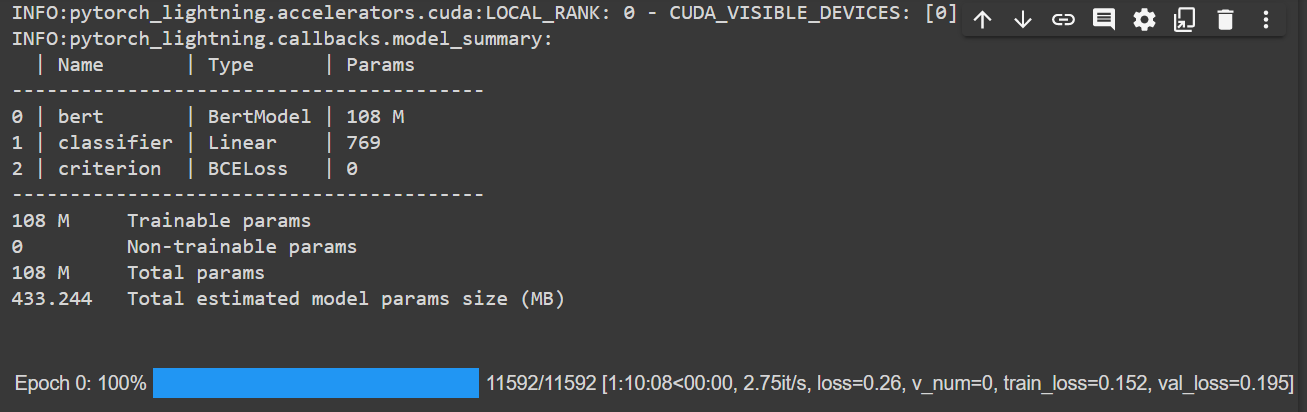

In [ ]:
trainer.test()